In [1]:
# Load necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn pre-processing & model selection
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir(r"/content/drive/My Drive/DSC680")

In [4]:
# Import baseball data to DataFrames
import os
import pandas as pd

#path="/content/drive/MyDrive/DSC680/People.csv"
# Read in the CSV
master_df = pd.read_csv('People.csv',usecols=['playerID','nameFirst','nameLast','bats','throws','debut','finalGame'])
fielding_df = pd.read_csv('Fielding.csv',usecols=['playerID','yearID','stint','teamID','lgID','POS','G','GS','InnOuts','PO','A','E','DP'])
batting_df = pd.read_csv('Batting.csv')
awards_df = pd.read_csv('AwardsPlayers.csv', usecols=['playerID','awardID','yearID'])
allstar_df = pd.read_csv('AllstarFull.csv', usecols=['playerID','yearID'])
hof_df = pd.read_csv('HallOfFame.csv',usecols=['playerID','yearID','votedBy','needed_note','inducted','category'])
appearances_df = pd.read_csv('Appearances.csv')


In [5]:
## Creating dictionaries for player stats and awards for a master dataset based on an excellent tutorial from Daniel Poston at datacamp.com
## (https://www.datacamp.com/tutorial/scikit-learn-tutorial-baseball-2)


#batting_df clean up

#print the first few rows of 'batting_df'
batting_df.head()

#Initialize dictionaries for player stats and years played

player_stats = {}
years_played = {}

#Create dictionaries for player stats and years played
for i, row in batting_df.iterrows():
    playerID = row['playerID']
    if playerID in player_stats:
        player_stats[playerID]['G'] = player_stats[playerID]['G'] + row['G']
        player_stats[playerID]['AB'] = player_stats[playerID]['AB'] + row['AB']
        player_stats[playerID]['R'] = player_stats[playerID]['R'] + row['R']
        player_stats[playerID]['H'] = player_stats[playerID]['H'] + row['H']
        player_stats[playerID]['2B'] = player_stats[playerID]['2B'] + row['2B']
        player_stats[playerID]['3B'] = player_stats[playerID]['3B'] + row['3B']
        player_stats[playerID]['HR'] = player_stats[playerID]['HR'] + row['HR']
        player_stats[playerID]['RBI'] = player_stats[playerID]['RBI'] + row['RBI']
        player_stats[playerID]['SB'] = player_stats[playerID]['SB'] + row['SB']
        player_stats[playerID]['BB'] = player_stats[playerID]['BB'] + row['BB']
        player_stats[playerID]['SO'] = player_stats[playerID]['SO'] + row['SO']
        player_stats[playerID]['IBB'] = player_stats[playerID]['IBB'] + row['IBB']
        player_stats[playerID]['HBP'] = player_stats[playerID]['HBP'] + row['HBP']
        player_stats[playerID]['SH'] = player_stats[playerID]['SH'] + row['SH']
        player_stats[playerID]['SF'] = player_stats[playerID]['SF'] + row['SF']
        years_played[playerID].append(row['yearID'])
    else:
        player_stats[playerID] = {}
        player_stats[playerID]['G'] = row['G']
        player_stats[playerID]['AB'] = row['AB']
        player_stats[playerID]['R'] = row['R']
        player_stats[playerID]['H'] = row['H']
        player_stats[playerID]['2B'] = row['2B']
        player_stats[playerID]['3B'] = row['3B']
        player_stats[playerID]['HR'] = row['HR']
        player_stats[playerID]['RBI'] = row['RBI']
        player_stats[playerID]['SB'] = row['SB']
        player_stats[playerID]['BB'] = row['BB']
        player_stats[playerID]['SO'] = row['SO']
        player_stats[playerID]['IBB'] = row['IBB']
        player_stats[playerID]['HBP'] = row['HBP']
        player_stats[playerID]['SH'] = row['SH']
        player_stats[playerID]['SF'] = row['SF']
        years_played[playerID] = []
        years_played[playerID].append(row['yearID'])

#Iterate through 'years_played' and add the number of years played to 'player_stats'
for k, v in years_played.items():
    player_stats[k]['Years_Played'] = len(list(set(v)))

#Initialize 'fielder_list'
fielder_list = []

#Add fielding states to 'player_stat" from 'fiedling_df'
for i, row in fielding_df.iterrows():
    playerID = row['playerID']
    Gf = row['G']
    GSf = row['GS']
    POf = row['PO']
    Af = row['A']
    Ef = row['E']
    DPf = row['DP']
    if playerID in player_stats and playerID in fielder_list:
        player_stats[playerID]['Gf'] = player_stats[playerID]['Gf'] + Gf
        player_stats[playerID]['GSf'] = player_stats[playerID]['GSf'] + GSf
        player_stats[playerID]['POf'] = player_stats[playerID]['POf'] + POf
        player_stats[playerID]['Af'] = player_stats[playerID]['Af'] + Af
        player_stats[playerID]['Ef'] = player_stats[playerID]['Ef'] + Ef
        player_stats[playerID]['DPf'] = player_stats[playerID]['DPf'] + DPf
    else:
        fielder_list.append(playerID)
        player_stats[playerID]['Gf'] = Gf
        player_stats[playerID]['GSf'] = GSf
        player_stats[playerID]['POf'] = POf
        player_stats[playerID]['Af'] = Af
        player_stats[playerID]['Ef'] = Ef
        player_stats[playerID]['DPf'] = DPf

#Print out unique awards from 'awards_df"
print(awards_df['awardID'].unique())
print(awards_df['awardID'].head())
print(awards_df['awardID'].tail())

#Create DataFrames for each award

mvp = awards_df[awards_df['awardID'] == 'Most Valuable Player']
roy = awards_df[awards_df['awardID'] == 'Rookie of the Year']
gg = awards_df[awards_df['awardID'] == 'Gold Glove']
ss = awards_df[awards_df['awardID'] == 'Silver Slugger']
ws_mvp = awards_df[awards_df['awardID'] == 'World Series MVP']

#Include each DataFrame in 'awards_list'
awards_list = [mvp,roy,gg,ss,ws_mvp]

#Initialize lists for each of the above DataFrames
mvp_list = []
roy_list = []
gg_list = []
ss_list = []
ws_mvp_list = []

#Include each of the above in lists in 'lists'
lists = [mvp_list,roy_list,gg_list,ss_list,ws_mvp_list]

#Add a count for each award for each player in 'player_stats'
for index, v in enumerate(awards_list):
    for i, row in v.iterrows():
        playerID = row['playerID']
        award = row['awardID']
        if playerID in player_stats and playerID in lists[index]:
            player_stats[playerID][award] += 1
        else:
            lists[index].append(playerID)
            player_stats[playerID][award] = 1

#Initialize 'allstar_df'
allstar_list = []

#Add a count for each Allstar game appearance for each player
for i, row in allstar_df.iterrows():
    playerID = row['playerID']
    if playerID in player_stats and playerID in allstar_list:
        player_stats[playerID]['AS_games'] += 1
    else:
        allstar_list.append(playerID)
        player_stats[playerID]['AS_games'] = 1

#Filter 'hof_df' to include only players
hof_df = hof_df[(hof_df['inducted'] == 'Y') & (hof_df['category'] == 'Player')]

#Indicate which players in 'player_stats' were inducted into the HoF
for i, row in hof_df.iterrows():
    playerID = row['playerID']
    if playerID in player_stats:
        player_stats[playerID]['HoF'] = 1
        player_stats[playerID]['votedBy'] = row['votedBy']

#Convert 'player_stats' into a DataFrame
stats_df = pd.DataFrame.from_dict(player_stats, orient='index')

#Add column for playerID form the 'stats_df' index
stats_df['playerID'] = stats_df.index

#Join 'stats_df' and 'master_df'
master_df = master_df.join(stats_df, on='playerID',how='inner', rsuffix='mstr')

#Inspect first row of 'master_df'
master_df.head()

print(appearances_df.head())

#Initialize a dictionay

pos_dict = {}

#Iterate through `appearances_df`

#Add a count for the number of appearances for each player at each position

#Also add a count for the number of games played for each player in each era.

for i, row in appearances_df.iterrows():
    ID = row['playerID']
    year = row['yearID']
    if ID in pos_dict:
        pos_dict[ID]['G_all'] = pos_dict[ID]['G_all'] + row['G_all']
        pos_dict[ID]['G_p'] = pos_dict[ID]['G_p'] + row['G_p']
        pos_dict[ID]['G_c'] = pos_dict[ID]['G_c'] + row['G_c']
        pos_dict[ID]['G_1b'] = pos_dict[ID]['G_1b'] + row['G_1b']
        pos_dict[ID]['G_2b'] = pos_dict[ID]['G_2b'] + row['G_2b']
        pos_dict[ID]['G_3b'] = pos_dict[ID]['G_3b'] + row['G_3b']
        pos_dict[ID]['G_ss'] = pos_dict[ID]['G_ss'] + row['G_ss']
        pos_dict[ID]['G_lf'] = pos_dict[ID]['G_lf'] + row['G_lf']
        pos_dict[ID]['G_cf'] = pos_dict[ID]['G_cf'] + row['G_cf']
        pos_dict[ID]['G_rf'] = pos_dict[ID]['G_rf'] + row['G_rf']
        pos_dict[ID]['G_of'] = pos_dict[ID]['G_of'] + row['G_of']
        pos_dict[ID]['G_dh'] = pos_dict[ID]['G_dh'] + row['G_dh']
        if year < 1920:
            pos_dict[ID]['pre1920'] = pos_dict[ID]['pre1920'] + row['G_all']
        elif 1941 >= year >= 1920:
            pos_dict[ID]['1920-41'] = pos_dict[ID]['1920-41'] + row['G_all']
        elif 1945 >= year >= 1942:
            pos_dict[ID]['1942-45'] = pos_dict[ID]['1942-45'] + row['G_all']
        elif 1962 >= year >= 1946:
            pos_dict[ID]['1946-62'] = pos_dict[ID]['1946-62'] + row['G_all']
        elif 1976 >= year >= 1963:
            pos_dict[ID]['1963-76'] = pos_dict[ID]['1963-76'] + row['G_all']
        elif 1992 >= year >= 1977:
            pos_dict[ID]['1977-92'] = pos_dict[ID]['1977-92'] + row['G_all']
        elif 2009 >= year >= 1993:
            pos_dict[ID]['1993-2009'] = pos_dict[ID]['1993-2009'] + row['G_all']
        elif year > 2009:
            pos_dict[ID]['post2009'] = pos_dict[ID]['post2009'] + row['G_all']

    else:
        pos_dict[ID] = {}
        pos_dict[ID]['G_all'] = row['G_all']
        pos_dict[ID]['G_p'] = row['G_p']
        pos_dict[ID]['G_c'] = row['G_c']
        pos_dict[ID]['G_1b'] = row['G_1b']
        pos_dict[ID]['G_2b'] = row['G_2b']
        pos_dict[ID]['G_3b'] = row['G_3b']
        pos_dict[ID]['G_ss'] = row['G_ss']
        pos_dict[ID]['G_lf'] = row['G_lf']
        pos_dict[ID]['G_cf'] = row['G_cf']
        pos_dict[ID]['G_rf'] = row['G_rf']
        pos_dict[ID]['G_of'] = row['G_of']
        pos_dict[ID]['G_dh'] = row['G_dh']
        pos_dict[ID]['pre1920'] = 0
        pos_dict[ID]['1920-41'] = 0
        pos_dict[ID]['1942-45'] = 0
        pos_dict[ID]['1946-62'] = 0
        pos_dict[ID]['1963-76'] = 0
        pos_dict[ID]['1977-92'] = 0
        pos_dict[ID]['1993-2009'] = 0
        pos_dict[ID]['post2009'] = 0
        if year < 1920:
            pos_dict[ID]['pre1920'] = row['G_all']
        elif 1941 >= year >= 1920:
            pos_dict[ID]['1920-41'] = row['G_all']
        elif 1945 >= year >= 1942:
            pos_dict[ID]['1942-45'] = row['G_all']
        elif 1962 >= year >= 1946:
            pos_dict[ID]['1946-62'] = row['G_all']
        elif 1976 >= year >= 1963:
            pos_dict[ID]['1963-76'] = row['G_all']
        elif 1992 >= year >= 1977:
            pos_dict[ID]['1977-92'] = row['G_all']
        elif 2009 >= year >= 1993:
            pos_dict[ID]['1993-2009'] = row['G_all']
        elif year > 2009:
            pos_dict[ID]['post2009'] = row['G_all']

#Convert the 'pos_dict' into a df
pos_df = pd.DataFrame.from_dict(pos_dict, orient='index')

#Print the columns
print(pos_df.columns)

#Print the first rows
print(pos_df.head())

#Create a list from the cloums of 'pos_df'
pos_col_list = pos_df.columns.tolist()

#Remove the string 'G_all'
pos_col_list.remove('G_all')

#Loop through the list and divide each column by the players total games played
for col in pos_col_list:
    column = col + '_percent'
    pos_df[column] = pos_df[col] / pos_df['G_all']

#Print out the first rows of 'pos_df'
print(pos_df.head())

# Filter `pos_df` to eliminate players who played 10% or more of their games as Pitchers or Catchers
pos_df = pos_df[(pos_df['G_p_percent'] < 0.1) &
                (pos_df['G_c_percent'] < 0.1)]

#Get infor on 'pos_df'
pos_df.info()

#Join 'pos_df' and 'master_df'
master_df = master_df.join(pos_df, on='playerID', how='right')

#Print out the first rows of 'master_df'
print(master_df.head())

['Pitching Triple Crown' 'Triple Crown' 'Baseball Magazine All-Star'
 'Most Valuable Player' 'TSN All-Star' 'TSN Guide MVP'
 'TSN Major League Player of the Year' 'TSN Pitcher of the Year'
 'TSN Player of the Year' 'Rookie of the Year' 'Babe Ruth Award'
 'Lou Gehrig Memorial Award' 'World Series MVP' 'Cy Young Award'
 'Gold Glove' 'TSN Fireman of the Year' 'All-Star Game MVP' 'Hutch Award'
 'Roberto Clemente Award' 'Rolaids Relief Man Award' 'NLCS MVP' 'ALCS MVP'
 'Silver Slugger' 'Branch Rickey Award' 'Hank Aaron Award'
 'TSN Reliever of the Year' 'Comeback Player of the Year'
 'Outstanding DH Award' 'Reliever of the Year Award' 'SIlver Slugger']
0    Pitching Triple Crown
1             Triple Crown
2    Pitching Triple Crown
3    Pitching Triple Crown
4             Triple Crown
Name: awardID, dtype: object
6526      TSN All-Star
6527      TSN All-Star
6528      TSN All-Star
6529    Silver Slugger
6530      TSN All-Star
Name: awardID, dtype: object
   yearID teamID lgID   playerID  G_

In [6]:
#Replace NC values with 'None'
master_df['votedBy'] = master_df['votedBy'].fillna('None')

#Filter the master_df to include only players who were voted into the HoF or Players who did not make it at all
master_df = master_df[(master_df['votedBy'] == 'None') |
                      (master_df['votedBy'] == 'BBWAA') | (master_df['votedBy'] == 'Run Off')]

#Inspect 'master_df'
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8653 entries, 21 to 20549
Data columns (total 77 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   playerID              8653 non-null   object 
 1   nameFirst             8624 non-null   object 
 2   nameLast              8653 non-null   object 
 3   bats                  8147 non-null   object 
 4   throws                8137 non-null   object 
 5   debut                 8651 non-null   object 
 6   finalGame             8651 non-null   object 
 7   G                     8653 non-null   int64  
 8   AB                    8653 non-null   int64  
 9   R                     8653 non-null   int64  
 10  H                     8653 non-null   int64  
 11  2B                    8653 non-null   int64  
 12  3B                    8653 non-null   int64  
 13  HR                    8653 non-null   int64  
 14  RBI                   8378 non-null   float64
 15  SB                 

In [7]:
#Create a function to convert the bats and throws columns to numeric
def bats_throws(col):
    if col == "R":
        return 1
    else:
        return 0
#Use the 'apply()' method to create numeric columns from the bats and throws columns
master_df['bats_R'] = master_df['bats'].apply(bats_throws)
master_df['throws_R'] = master_df['throws'].apply(bats_throws)

#Print out the first rows of 'master_df'
print(master_df.head())


      playerID nameFirst     nameLast bats throws       debut   finalGame  \
21   abercda01     Frank  Abercrombie  NaN    NaN  1871-10-21  1871-10-21   
111   addybo01       Bob         Addy    L      L  1871-05-06  1877-10-06   
259  allisar01       Art      Allison  NaN    NaN  1871-05-04  1876-10-05   
509  armstbo01    Robert    Armstrong  NaN    NaN  1871-06-26  1871-08-29   
848  barkeal01        Al       Barker  NaN    NaN  1871-06-01  1871-06-01   

       G    AB    R  ...  pre1920_percent  1920-41_percent  1942-45_percent  \
21     1     4    0  ...              1.0              0.0              0.0   
111  274  1231  227  ...              1.0              0.0              0.0   
259  168   741  106  ...              1.0              0.0              0.0   
509   12    49    9  ...              1.0              0.0              0.0   
848    1     4    0  ...              1.0              0.0              0.0   

     1946-62_percent  1963-76_percent  1977-92_percent  1993-2

In [8]:
# Import datetime
from datetime import datetime as dt

# Convert the `debut` column to datetime
master_df['debut'] = pd.to_datetime(master_df['debut'])
# Convert the `finalGame` column to datetime
master_df['finalGame'] = pd.to_datetime(master_df['finalGame'])

# Create new columns for debutYear and finalYear
master_df['debutYear'] = pd.to_numeric(master_df['debut'].dt.strftime('%Y'), errors='coerce')
master_df['finalYear'] = pd.to_numeric(master_df['finalGame'].dt.strftime('%Y'), errors='coerce')

# Return the first rows of `master_df`
print(master_df.head())

      playerID nameFirst     nameLast bats throws      debut  finalGame    G  \
21   abercda01     Frank  Abercrombie  NaN    NaN 1871-10-21 1871-10-21    1   
111   addybo01       Bob         Addy    L      L 1871-05-06 1877-10-06  274   
259  allisar01       Art      Allison  NaN    NaN 1871-05-04 1876-10-05  168   
509  armstbo01    Robert    Armstrong  NaN    NaN 1871-06-26 1871-08-29   12   
848  barkeal01        Al       Barker  NaN    NaN 1871-06-01 1871-06-01    1   

       AB    R  ...  1942-45_percent  1946-62_percent  1963-76_percent  \
21      4    0  ...              0.0              0.0              0.0   
111  1231  227  ...              0.0              0.0              0.0   
259   741  106  ...              0.0              0.0              0.0   
509    49    9  ...              0.0              0.0              0.0   
848     4    0  ...              0.0              0.0              0.0   

     1977-92_percent  1993-2009_percent  post2009_percent  bats_R  throws_

In [9]:
# Eliminating unnecessary columns
df = master_df.drop(['votedBy', 'IBB', 'bats', 'throws', 'GSf', 'POf','Gf', 'playerIDmstr'], axis=1)

# Print `df` columns
print(df.columns)

# Print a list of null values
print(df.isnull().sum(axis=0).tolist())

Index(['playerID', 'nameFirst', 'nameLast', 'debut', 'finalGame', 'G', 'AB',
       'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'BB', 'SO', 'HBP', 'SH', 'SF',
       'Years_Played', 'Af', 'Ef', 'DPf', 'HoF', 'Most Valuable Player',
       'AS_games', 'Gold Glove', 'Rookie of the Year', 'World Series MVP',
       'Silver Slugger', 'G_all', 'G_p', 'G_c', 'G_1b', 'G_2b', 'G_3b', 'G_ss',
       'G_lf', 'G_cf', 'G_rf', 'G_of', 'G_dh', 'pre1920', '1920-41', '1942-45',
       '1946-62', '1963-76', '1977-92', '1993-2009', 'post2009', 'G_p_percent',
       'G_c_percent', 'G_1b_percent', 'G_2b_percent', 'G_3b_percent',
       'G_ss_percent', 'G_lf_percent', 'G_cf_percent', 'G_rf_percent',
       'G_of_percent', 'G_dh_percent', 'pre1920_percent', '1920-41_percent',
       '1942-45_percent', '1946-62_percent', '1963-76_percent',
       '1977-92_percent', '1993-2009_percent', 'post2009_percent', 'bats_R',
       'throws_R', 'debutYear', 'finalYear'],
      dtype='object')
[0, 29, 0, 2, 2, 0, 0, 0, 0, 

In [10]:
df.head()

,playerID,nameFirst,nameLast,debut,finalGame,G,AB,R,H,2B,...,1942-45_percent,1946-62_percent,1963-76_percent,1977-92_percent,1993-2009_percent,post2009_percent,bats_R,throws_R,debutYear,finalYear
21,abercda01,Frank,Abercrombie,1871-10-21,1871-10-21,1,4,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1871.0,1871.0
111,addybo01,Bob,Addy,1871-05-06,1877-10-06,274,1231,227,341,36,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1871.0,1877.0
259,allisar01,Art,Allison,1871-05-04,1876-10-05,168,741,106,188,19,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1871.0,1876.0
509,armstbo01,Robert,Armstrong,1871-06-26,1871-08-29,12,49,9,11,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1871.0,1871.0
848,barkeal01,Al,Barker,1871-06-01,1871-06-01,1,4,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1871.0,1871.0


In [11]:
# Fill null values in numeric columns with 0
fill_cols = ['AS_games', 'Silver Slugger', 'Rookie of the Year',
             'Gold Glove', 'Most Valuable Player', 'HoF',
             '1977-92', 'pre1920', '1942-45', '1946-62',
             '1963-76', '1920-41', '1993-2009', 'HBP', 'SB',
             'SF', 'SH', 'RBI', 'SO', 'World Series MVP',
             'G_dh_percent', 'G_dh', 'Af', 'DPf', 'Ef']

for col in fill_cols:
    df[col] = df[col].fillna(0)

# Drop any additional rows with null values
df = df.dropna()

# Check to make sure null values have been removed
print(df.isnull().sum(axis=0).tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [12]:
df.head(10)

,playerID,nameFirst,nameLast,debut,finalGame,G,AB,R,H,2B,...,1942-45_percent,1946-62_percent,1963-76_percent,1977-92_percent,1993-2009_percent,post2009_percent,bats_R,throws_R,debutYear,finalYear
21,abercda01,Frank,Abercrombie,1871-10-21,1871-10-21,1,4,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1871.0,1871.0
111,addybo01,Bob,Addy,1871-05-06,1877-10-06,274,1231,227,341,36,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1871.0,1877.0
259,allisar01,Art,Allison,1871-05-04,1876-10-05,168,741,106,188,19,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1871.0,1876.0
509,armstbo01,Robert,Armstrong,1871-06-26,1871-08-29,12,49,9,11,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1871.0,1871.0
848,barkeal01,Al,Barker,1871-06-01,1871-06-01,1,4,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1871.0,1871.0
893,barnero01,Ross,Barnes,1871-05-05,1881-09-21,499,2391,698,860,146,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1871.0,1881.0
945,barrofr01,Frank,Barrows,1871-05-20,1871-10-07,18,86,13,13,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1871.0,1871.0
995,bassjo01,John,Bass,1871-05-04,1877-08-20,25,100,19,29,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1871.0,1877.0
1028,battijo01,Joe,Battin,1871-08-11,1890-05-28,480,1953,228,439,51,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1871.0,1890.0
1116,beaveed01,Edward,Beavens,1871-05-09,1872-08-22,13,58,13,15,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1871.0,1872.0


**Feature Engineering: Creating New Features**

In [13]:
# Create Batting Average (`AVE`) column
df['AVE'] = df['H'] / df['AB']

# Create On Base Percent (`OBP`) column
plate_appearances = (df['AB'] + df['BB'] + df['SF'] + df['SH'] + df['HBP'])
df['OBP'] = (df['H'] + df['BB'] + df['HBP']) / plate_appearances

# Create Slugging Percent (`Slug_Percent`) column
single = ((df['H'] - df['2B']) - df['3B']) - df['HR']
df['Slug_Percent'] = ((df['HR'] * 4) + (df['3B'] * 3) + (df['2B'] * 2) + single) / df['AB']

# Create On Base plus Slugging Percent (`OPS`) column
hr = df['HR'] * 4
triple = df['3B'] * 3
double = df['2B'] * 2
df['OPS'] = df['OBP'] + df['Slug_Percent']

'''
# Create Batting Runs column for modern metric
df['batting_R'] = df['R'] + df['RBI'] + df['HR']

# Create Base Running Runs column for modern metric
#df['base_running_R'] = df['SB'] + df['CS']

# Create Fielding Runs column for modern metric
df['fielding_R'] = df['Af'] + df['Ef'] + df['DPf']
'''
# Double check the `df` columns
print(df.columns)

Index(['playerID', 'nameFirst', 'nameLast', 'debut', 'finalGame', 'G', 'AB',
       'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'BB', 'SO', 'HBP', 'SH', 'SF',
       'Years_Played', 'Af', 'Ef', 'DPf', 'HoF', 'Most Valuable Player',
       'AS_games', 'Gold Glove', 'Rookie of the Year', 'World Series MVP',
       'Silver Slugger', 'G_all', 'G_p', 'G_c', 'G_1b', 'G_2b', 'G_3b', 'G_ss',
       'G_lf', 'G_cf', 'G_rf', 'G_of', 'G_dh', 'pre1920', '1920-41', '1942-45',
       '1946-62', '1963-76', '1977-92', '1993-2009', 'post2009', 'G_p_percent',
       'G_c_percent', 'G_1b_percent', 'G_2b_percent', 'G_3b_percent',
       'G_ss_percent', 'G_lf_percent', 'G_cf_percent', 'G_rf_percent',
       'G_of_percent', 'G_dh_percent', 'pre1920_percent', '1920-41_percent',
       '1942-45_percent', '1946-62_percent', '1963-76_percent',
       '1977-92_percent', '1993-2009_percent', 'post2009_percent', 'bats_R',
       'throws_R', 'debutYear', 'finalYear', 'AVE', 'OBP', 'Slug_Percent',
       'OPS'],
      d

In [14]:
df.head()

,playerID,nameFirst,nameLast,debut,finalGame,G,AB,R,H,2B,...,1993-2009_percent,post2009_percent,bats_R,throws_R,debutYear,finalYear,AVE,OBP,Slug_Percent,OPS
21,abercda01,Frank,Abercrombie,1871-10-21,1871-10-21,1,4,0,0,0,...,0.0,0.0,0,0,1871.0,1871.0,0.000000,0.000000,0.000000,0.000000
111,addybo01,Bob,Addy,1871-05-06,1877-10-06,274,1231,227,341,36,...,0.0,0.0,0,0,1871.0,1877.0,0.277011,0.288569,0.329813,0.618382
259,allisar01,Art,Allison,1871-05-04,1876-10-05,168,741,106,188,19,...,0.0,0.0,0,0,1871.0,1876.0,0.253711,0.258713,0.304993,0.563706
509,armstbo01,Robert,Armstrong,1871-06-26,1871-08-29,12,49,9,11,2,...,0.0,0.0,0,0,1871.0,1871.0,0.224490,0.224490,0.306122,0.530612
848,barkeal01,Al,Barker,1871-06-01,1871-06-01,1,4,0,1,0,...,0.0,0.0,0,0,1871.0,1871.0,0.250000,0.400000,0.250000,0.650000


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8622 entries, 21 to 20549
Data columns (total 77 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   playerID              8622 non-null   object        
 1   nameFirst             8622 non-null   object        
 2   nameLast              8622 non-null   object        
 3   debut                 8622 non-null   datetime64[ns]
 4   finalGame             8622 non-null   datetime64[ns]
 5   G                     8622 non-null   int64         
 6   AB                    8622 non-null   int64         
 7   R                     8622 non-null   int64         
 8   H                     8622 non-null   int64         
 9   2B                    8622 non-null   int64         
 10  3B                    8622 non-null   int64         
 11  HR                    8622 non-null   int64         
 12  RBI                   8622 non-null   float64       
 13  SB              

In [16]:
'''
import pandas as pd

# Load the data into a Pandas DataFrame
df = pd.read_csv('path/to/database.csv')

# Calculate the necessary components of WAR
batting_runs = df['R'] + df['RBI'] + df['HR']
base_running_runs = df['SB'] + df['CS']
fielding_runs = df['Af'] + df['Ef'] + df['DPf']
positional_adjustment = 0 # You will need to determine this value based on the player's position
league_adjustment = 0 # You will need to determine this value based on the league
replacement_runs = 20 # This is the number of runs a replacement-level player would create in the same number of plate appearances
runs_per_win = 10 # This is the number of runs it takes to create one win

# Calculate WAR for each player
df['WAR'] = (batting_runs + base_running_runs + fielding_runs + positional_adjustment + league_adjustment + replacement_runs) / runs_per_win

# Print the results
print(df[['nameFirst', 'nameLast', 'WAR']])
'''

"\nimport pandas as pd\n\n# Load the data into a Pandas DataFrame\ndf = pd.read_csv('path/to/database.csv')\n\n# Calculate the necessary components of WAR\nbatting_runs = df['R'] + df['RBI'] + df['HR']\nbase_running_runs = df['SB'] + df['CS']\nfielding_runs = df['Af'] + df['Ef'] + df['DPf']\npositional_adjustment = 0 # You will need to determine this value based on the player's position\nleague_adjustment = 0 # You will need to determine this value based on the league\nreplacement_runs = 20 # This is the number of runs a replacement-level player would create in the same number of plate appearances\nruns_per_win = 10 # This is the number of runs it takes to create one win\n\n# Calculate WAR for each player\ndf['WAR'] = (batting_runs + base_running_runs + fielding_runs + positional_adjustment + league_adjustment + replacement_runs) / runs_per_win\n\n# Print the results\nprint(df[['nameFirst', 'nameLast', 'WAR']])\n"

In [17]:
'''
import pandas as pd
url = 'https://www.baseball-reference.com/leaders/WAR_bat_career.shtml'
df_war1 = pd.read_html(url)[0]
df_war1.to_csv('WAR_bat_career.csv', index=False)
'''

"\nimport pandas as pd\nurl = 'https://www.baseball-reference.com/leaders/WAR_bat_career.shtml'\ndf_war1 = pd.read_html(url)[0]\ndf_war1.to_csv('WAR_bat_career.csv', index=False)\n"

In [18]:
'''
import pandas as pd
import re

df_war1 = pd.read_csv('WAR_bat_career.csv')
#df['PlayerID'] = df['Player (yrs, age)'].str.replace(r'\(\d{1,2}\)', '').str.strip()

df_war1['PlayerName'] = df_war1['Player (yrs, age)'].str.replace(r'\(\d+\)|\+', '', regex=True)

df_war1.head()
'''

"\nimport pandas as pd\nimport re\n\ndf_war1 = pd.read_csv('WAR_bat_career.csv')\n#df['PlayerID'] = df['Player (yrs, age)'].str.replace(r'\\(\\d{1,2}\\)', '').str.strip()\n\ndf_war1['PlayerName'] = df_war1['Player (yrs, age)'].str.replace(r'\\(\\d+\\)|\\+', '', regex=True)\n\ndf_war1.head()\n"

In [19]:
'''
from lahman import LahmanDB

db = LahmanDB()

# Get all players from 2016 season
players = db.PlayerBattingByYearID.query("yearID == 2016")

# Calculate WAR for each player
for player in players:
    war = player.WAR
    print(player.nameFirst, player.nameLast, war)
'''

'\nfrom lahman import LahmanDB\n\ndb = LahmanDB()\n\n# Get all players from 2016 season\nplayers = db.PlayerBattingByYearID.query("yearID == 2016")\n\n# Calculate WAR for each player\nfor player in players:\n    war = player.WAR\n    print(player.nameFirst, player.nameLast, war)\n'

In [20]:
'''
# Batting Runs
import pandas as pd

batting = pd.read_csv('Batting.csv')
batting['Batting Runs'] = (batting['H'] - batting['2B'] - batting['3B'] - batting['HR']) +
(1.4 * batting['2B']) + (1.8 * batting['3B']) + (2.1 * batting['HR']) + (0.1 * (batting['BB'] +
batting['HBP'] - batting['IBB'])) + (0.9 * batting['SB']) - (0.6 * (batting['CS'] + batting['GIDP']))
'''

"\n# Batting Runs\nimport pandas as pd\n\nbatting = pd.read_csv('Batting.csv')\nbatting['Batting Runs'] = (batting['H'] - batting['2B'] - batting['3B'] - batting['HR']) +\n(1.4 * batting['2B']) + (1.8 * batting['3B']) + (2.1 * batting['HR']) + (0.1 * (batting['BB'] +\nbatting['HBP'] - batting['IBB'])) + (0.9 * batting['SB']) - (0.6 * (batting['CS'] + batting['GIDP']))\n"

In [21]:
# Request daily baseball WAR data from Baseball Referenc.com
import requests

url = 'https://www.baseball-reference.com/data/war_daily_bat.txt'
response = requests.get(url)

with open('data.csv', 'wb') as f:
    f.write(response.content)

In [22]:
df_war = pd.read_csv('data.csv')

In [23]:
df_war.head(5)

,name_common,age,mlb_ID,player_ID,year_ID,team_ID,stint_ID,lg_ID,PA,G,...,oppRpG_rep,pyth_exponent,pyth_exponent_rep,waa_win_perc,waa_win_perc_off,waa_win_perc_def,waa_win_perc_rep,OPS_plus,TOB_lg,TB_lg
0,David Aardsma,22.0,430911.0,aardsda01,2004,SFG,1,NL,0.0,11,...,4.67092,1.890,1.890,0.500,0.500,0.5,0.5000,NaN,0.000,0.000
1,David Aardsma,24.0,430911.0,aardsda01,2006,CHC,1,NL,3.0,43,...,4.86457,1.912,1.913,0.499,0.499,0.5,0.4998,-100.0,0.694,0.896
2,David Aardsma,25.0,430911.0,aardsda01,2007,CHW,1,AL,0.0,2,...,4.85895,1.912,1.912,0.500,0.500,0.5,0.5000,NaN,0.000,0.000
3,David Aardsma,26.0,430911.0,aardsda01,2008,BOS,1,AL,1.0,5,...,4.69650,1.893,1.894,0.497,0.497,0.5,0.4992,-100.0,0.345,0.434
4,David Aardsma,27.0,430911.0,aardsda01,2009,SEA,1,AL,0.0,3,...,4.79788,1.905,1.905,0.500,0.500,0.5,0.5000,NaN,0.000,0.000


In [24]:
df_war.rename(columns = {'player_ID':'playerID'}, inplace = True)

In [25]:
df_war.head()

,name_common,age,mlb_ID,playerID,year_ID,team_ID,stint_ID,lg_ID,PA,G,...,oppRpG_rep,pyth_exponent,pyth_exponent_rep,waa_win_perc,waa_win_perc_off,waa_win_perc_def,waa_win_perc_rep,OPS_plus,TOB_lg,TB_lg
0,David Aardsma,22.0,430911.0,aardsda01,2004,SFG,1,NL,0.0,11,...,4.67092,1.890,1.890,0.500,0.500,0.5,0.5000,NaN,0.000,0.000
1,David Aardsma,24.0,430911.0,aardsda01,2006,CHC,1,NL,3.0,43,...,4.86457,1.912,1.913,0.499,0.499,0.5,0.4998,-100.0,0.694,0.896
2,David Aardsma,25.0,430911.0,aardsda01,2007,CHW,1,AL,0.0,2,...,4.85895,1.912,1.912,0.500,0.500,0.5,0.5000,NaN,0.000,0.000
3,David Aardsma,26.0,430911.0,aardsda01,2008,BOS,1,AL,1.0,5,...,4.69650,1.893,1.894,0.497,0.497,0.5,0.4992,-100.0,0.345,0.434
4,David Aardsma,27.0,430911.0,aardsda01,2009,SEA,1,AL,0.0,3,...,4.79788,1.905,1.905,0.500,0.500,0.5,0.5000,NaN,0.000,0.000


In [26]:
df_war.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121396 entries, 0 to 121395
Data columns (total 49 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   name_common         121396 non-null  object 
 1   age                 120011 non-null  float64
 2   mlb_ID              113008 non-null  float64
 3   playerID            121396 non-null  object 
 4   year_ID             121396 non-null  int64  
 5   team_ID             121396 non-null  object 
 6   stint_ID            121396 non-null  int64  
 7   lg_ID               120660 non-null  object 
 8   PA                  120594 non-null  float64
 9   G                   121396 non-null  int64  
 10  Inn                 76488 non-null   float64
 11  runs_bat            121396 non-null  float64
 12  runs_br             121396 non-null  float64
 13  runs_dp             121396 non-null  float64
 14  runs_field          121396 non-null  float64
 15  runs_infield        76488 non-null

In [27]:
# Make a simpler df_war dataframe to include more modern metrics for positional players
df_waroff = df_war[['name_common','playerID', 'runs_br', 'runs_dp','runs_field','WAR', 'WAR_off']]

In [28]:
df_waroff.tail(100)

,name_common,playerID,runs_br,runs_dp,runs_field,WAR,WAR_off
121296,Ben Zobrist,zobribe01,3.41,2.13,3.0,4.37,4.27
121297,Ben Zobrist,zobribe01,-0.34,-0.21,-2.0,1.17,1.58
121298,Ben Zobrist,zobribe01,-0.56,0.94,-2.0,1.25,1.66
121299,Ben Zobrist,zobribe01,1.97,-0.30,-2.0,3.39,4.04
121300,Ben Zobrist,zobribe01,-2.46,1.31,-1.0,0.10,0.34
...,...,...,...,...,...,...,...
121391,Dutch Zwilling,zwilldu01,-0.52,0.00,4.0,4.14,3.62
121392,Dutch Zwilling,zwilldu01,0.07,0.00,-1.0,-0.67,-0.54
121393,Tony Zych,zychto01,0.00,0.00,0.0,NaN,NaN
121394,Tony Zych,zychto01,0.00,0.00,0.0,NaN,NaN


In [29]:
# Filter out the NaN's and replace them with 0's.
df_waroff.fillna(0, inplace=True)

In [30]:
df_waroff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121396 entries, 0 to 121395
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   name_common  121396 non-null  object 
 1   playerID     121396 non-null  object 
 2   runs_br      121396 non-null  float64
 3   runs_dp      121396 non-null  float64
 4   runs_field   121396 non-null  float64
 5   WAR          121396 non-null  float64
 6   WAR_off      121396 non-null  float64
dtypes: float64(5), object(2)
memory usage: 6.5+ MB


In [31]:
# Make a pivot table from the WAR dataframe and index by 'playerID' and 'name_common'
df_pivot = pd.pivot_table(
    data=df_waroff,
    index=['playerID','name_common'],
    aggfunc='sum',
    values=['WAR','WAR_off','runs_br','runs_dp','runs_field'] )

In [32]:
df_pivot.tail(5)

,,WAR,WAR_off,runs_br,runs_dp,runs_field
playerID,name_common,,,,,
zupofr01,Frank Zupo,-0.07,0.04,0.37,0.17,0.0
zuvelpa01,Paul Zuvella,-2.34,-0.63,-1.22,1.71,-15.4
zuverge01,George Zuverink,-0.33,-0.32,0.23,-0.33,0.0
zwilldu01,Dutch Zwilling,8.49,7.04,-1.60,0.00,11.0
zychto01,Tony Zych,0.00,0.00,0.00,0.00,0.0


In [33]:
# Flatten the pivot table to a dataframe called 'war_df'
war_df = df_pivot.reset_index()

In [34]:
war_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22907 entries, 0 to 22906
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   playerID     22907 non-null  object 
 1   name_common  22907 non-null  object 
 2   WAR          22907 non-null  float64
 3   WAR_off      22907 non-null  float64
 4   runs_br      22907 non-null  float64
 5   runs_dp      22907 non-null  float64
 6   runs_field   22907 non-null  float64
dtypes: float64(5), object(2)
memory usage: 1.2+ MB


In [35]:
# Export the 'war_df' dataframe to a csv file
war_df.to_csv('MLB_War_Offense.csv', index = True)

In [36]:
# Print WAR for some famous players
print(war_df.loc[war_df['name_common'] == 'Frank Robinson'])
print(war_df.loc[war_df['name_common'] == 'Babe Ruth'])
print(war_df.loc[war_df['name_common'] == 'Barry Bonds'])
print(war_df.loc[war_df['name_common'] == 'Ted Williams'])

        playerID     name_common     WAR  WAR_off  runs_br  runs_dp  \
17466  robinfr02  Frank Robinson  107.25   106.91    34.51   -25.45   

       runs_field  
17466        26.3  
       playerID name_common    WAR  WAR_off  runs_br  runs_dp  runs_field
17943  ruthba01   Babe Ruth  162.2   154.46     -8.5     0.38        79.0
       playerID  name_common     WAR  WAR_off  runs_br  runs_dp  runs_field
1875  bondsba01  Barry Bonds  162.77   143.61    43.59     5.61       143.8
        playerID   name_common     WAR  WAR_off  runs_br  runs_dp  runs_field
22237  willite01  Ted Williams  121.79    125.1     4.69     7.22       -22.2


In [37]:
# Print WAR for Ken Griffey Jr.
print(war_df.loc[war_df['playerID'] == 'griffke02'])

       playerID      name_common    WAR  WAR_off  runs_br  runs_dp  runs_field
8008  griffke02  Ken Griffey Jr.  83.84    84.59     15.7     9.15       -49.6


In [38]:
# Merge the batting dataframe with war dataframe
df = pd.merge(df, war_df, on='playerID')

In [39]:
df.head(10)

,playerID,nameFirst,nameLast,debut,finalGame,G,AB,R,H,2B,...,AVE,OBP,Slug_Percent,OPS,name_common,WAR,WAR_off,runs_br,runs_dp,runs_field
0,abercda01,Frank,Abercrombie,1871-10-21,1871-10-21,1,4,0,0,0,...,0.000000,0.000000,0.000000,0.000000,Frank Abercrombie,-0.07,-0.07,0.00,0.0,0.0
1,addybo01,Bob,Addy,1871-05-06,1877-10-06,274,1231,227,341,36,...,0.277011,0.288569,0.329813,0.618382,Bob Addy,2.92,2.94,-2.23,0.0,2.0
2,allisar01,Art,Allison,1871-05-04,1876-10-05,168,741,106,188,19,...,0.253711,0.258713,0.304993,0.563706,Art Allison,0.23,0.42,1.09,0.0,-2.0
3,barkeal01,Al,Barker,1871-06-01,1871-06-01,1,4,0,1,0,...,0.250000,0.400000,0.250000,0.650000,Al Barker,0.03,0.03,0.01,0.0,0.0
4,barnero01,Ross,Barnes,1871-05-05,1881-09-21,499,2391,698,860,146,...,0.359682,0.389310,0.467587,0.856897,Ross Barnes,28.03,24.49,5.20,0.0,57.0
5,barrofr01,Frank,Barrows,1871-05-20,1871-10-07,18,86,13,13,2,...,0.151163,0.151163,0.197674,0.348837,Frank Barrows,-0.87,-0.70,0.30,0.0,-3.0
6,bassjo01,John,Bass,1871-05-04,1877-08-20,25,100,19,29,2,...,0.290000,0.310680,0.600000,0.910680,John Bass,0.45,0.67,-0.72,0.0,-4.0
7,battijo01,Joe,Battin,1871-08-11,1890-05-28,480,1953,228,439,51,...,0.224782,0.240341,0.281106,0.521447,Joe Battin,6.35,2.25,1.60,0.0,49.0
8,bellast01,Steve,Bellan,1871-05-09,1873-06-09,60,275,52,69,9,...,0.250909,0.279720,0.305455,0.585175,Steve Bellan,-0.47,0.29,-1.81,0.0,-12.0
9,berkena01,Nate,Berkenstock,1871-10-30,1871-10-30,1,4,0,0,0,...,0.000000,0.000000,0.000000,0.000000,Nate Berkenstock,-0.12,-0.12,0.00,0.0,0.0


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8536 entries, 0 to 8535
Data columns (total 83 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   playerID              8536 non-null   object        
 1   nameFirst             8536 non-null   object        
 2   nameLast              8536 non-null   object        
 3   debut                 8536 non-null   datetime64[ns]
 4   finalGame             8536 non-null   datetime64[ns]
 5   G                     8536 non-null   int64         
 6   AB                    8536 non-null   int64         
 7   R                     8536 non-null   int64         
 8   H                     8536 non-null   int64         
 9   2B                    8536 non-null   int64         
 10  3B                    8536 non-null   int64         
 11  HR                    8536 non-null   int64         
 12  RBI                   8536 non-null   float64       
 13  SB                

In [41]:
# Filter the `df` for the remaining Hall of Fame members in the data
df_hof = df[df['HoF'] == 1]

# Print the length of the new DataFrame
print(len(df_hof))

77


In [42]:
df_hof.head(10)

,playerID,nameFirst,nameLast,debut,finalGame,G,AB,R,H,2B,...,AVE,OBP,Slug_Percent,OPS,name_common,WAR,WAR_off,runs_br,runs_dp,runs_field
780,keelewi01,Willie,Keeler,1892-09-30,1910-09-05,2123,8591,1719,2932,241,...,0.341287,0.387819,0.414620,0.802439,Willie Keeler,54.25,53.07,-6.28,0.00,30.0
887,lajoina01,Nap,Lajoie,1896-08-12,1916-08-26,2480,9590,1504,3243,657,...,0.338165,0.372144,0.466319,0.838463,Nap Lajoie,106.90,97.82,-10.92,0.00,83.0
928,wagneho01,Honus,Wagner,1897-07-19,1917-09-17,2794,10439,1739,3420,643,...,0.327618,0.383725,0.466520,0.850245,Honus Wagner,130.98,123.41,33.87,0.00,85.0
1222,cobbty01,Ty,Cobb,1905-08-30,1928-09-11,3035,11436,2247,4189,724,...,0.366299,0.423227,0.511892,0.935119,Ty Cobb,151.38,151.62,54.17,0.00,0.0
1282,collied01,Eddie,Collins,1906-09-17,1930-08-05,2826,9949,1821,3315,438,...,0.333199,0.406330,0.428988,0.835318,Eddie Collins,124.21,120.14,39.23,0.00,35.0
1353,speaktr01,Tris,Speaker,1907-09-12,1928-08-30,2789,10195,1882,3514,792,...,0.344679,0.416917,0.500343,0.917260,Tris Speaker,134.94,125.11,3.95,0.00,92.0
1689,maranra01,Rabbit,Maranville,1912-09-10,1935-09-29,2670,10078,1255,2605,380,...,0.258484,0.309435,0.339651,0.649086,Rabbit Maranville,44.09,31.07,5.24,-0.38,130.0
1874,heilmha01,Harry,Heilmann,1914-05-16,1932-05-31,2148,7787,1291,2660,542,...,0.341595,0.396875,0.520483,0.917358,Harry Heilmann,72.19,76.88,-3.11,0.00,-44.0
1922,ruthba01,Babe,Ruth,1914-07-11,1935-05-30,2503,8398,2174,2873,506,...,0.342105,0.468915,0.689807,1.158722,Babe Ruth,162.20,154.46,-8.50,0.38,79.0
1982,hornsro01,Rogers,Hornsby,1915-09-10,1937-07-20,2259,8173,1579,2930,541,...,0.358497,0.423852,0.576532,1.000385,Rogers Hornsby,127.11,121.85,-8.26,0.32,54.0


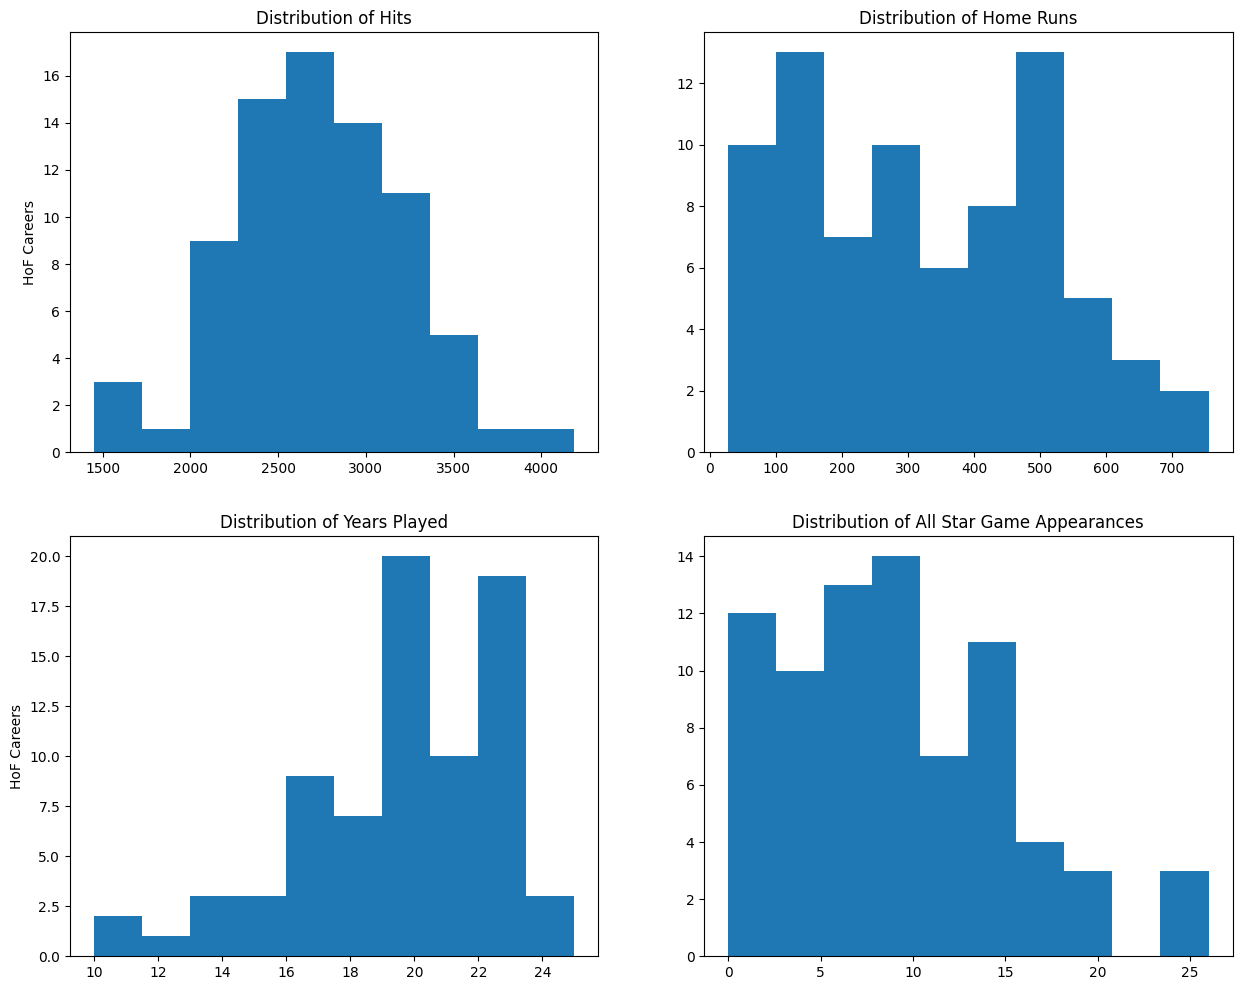

In [43]:
# Import the `pyplot` module from `matplotlib`
import matplotlib.pyplot as plt

# Initialize the figure and add subplots
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

# Create distribution plots for Hits, Home Runs, Years Played and All Star Games
ax1.hist(df_hof['H'])
ax1.set_title('Distribution of Hits')
ax1.set_ylabel('HoF Careers')
ax2.hist(df_hof['HR'])
ax2.set_title('Distribution of Home Runs')
ax3.hist(df_hof['Years_Played'])
ax3.set_title('Distribution of Years Played')
ax3.set_ylabel('HoF Careers')
ax4.hist(df_hof['AS_games'])
ax4.set_title('Distribution of All Star Game Appearances')
# Show the plot
plt.show()

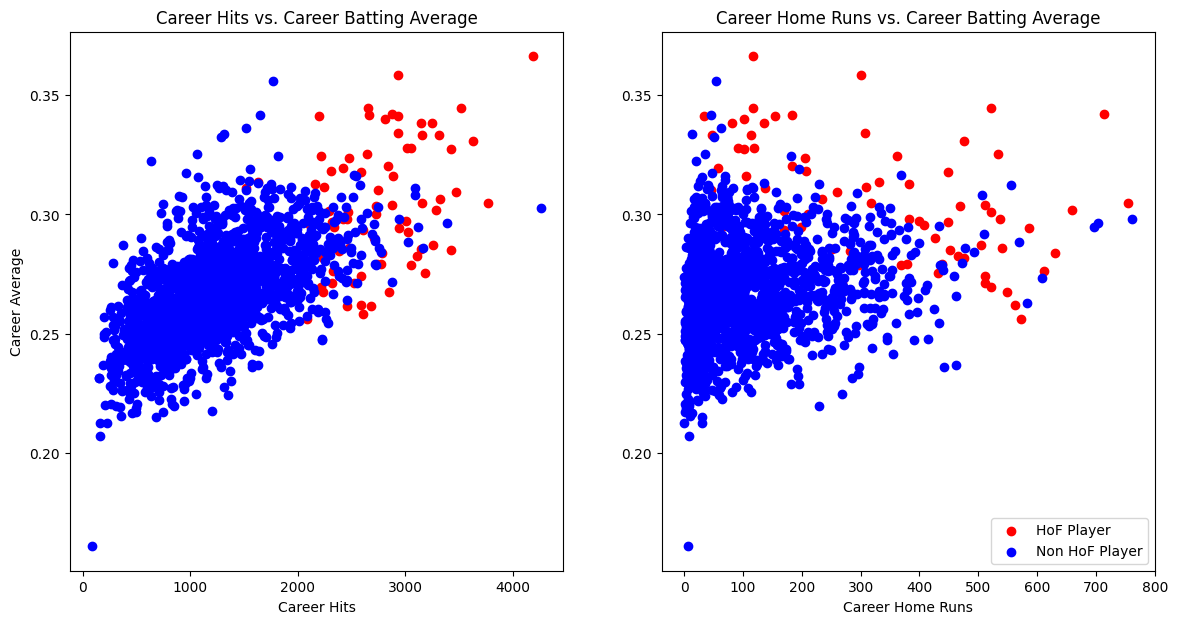

In [44]:
# Filter `df` for players with 10 or more years of experience
df_10 = df[(df['Years_Played'] >= 10) & (df['HoF'] == 0)]

# Initialize the figure and add subplots
fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# Create Scatter plots for Hits vs. Average and Home Runs vs. Average
ax1.scatter(df_hof['H'], df_hof['AVE'], c='r', label='HoF Player')
ax1.scatter(df_10['H'], df_10['AVE'], c='b', label='Non HoF Player')
ax1.set_title('Career Hits vs. Career Batting Average')
ax1.set_xlabel('Career Hits')
ax1.set_ylabel('Career Average')
ax2.scatter(df_hof['HR'], df_hof['AVE'], c='r', label='HoF Player')
ax2.scatter(df_10['HR'], df_10['AVE'], c='b', label='Non HoF Player')
ax2.set_title('Career Home Runs vs. Career Batting Average')
ax2.set_xlabel('Career Home Runs')
ax2.legend(loc='lower right', scatterpoints=1)

# Show the plot
plt.show()

In [45]:
# Check for null values
print(df.isnull().sum(axis=0).tolist())

# Eliminate rows with null values
df = df.dropna()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 78, 65, 78, 78, 0, 0, 0, 0, 0, 0]


In [46]:
#Create column for years since retirement
df['YSLS'] = 2022 - df['finalYear']

#Filter 'df' for players who retired more that 15 yrs ago
df_hitters = df[df['YSLS'] > 15]

print(df_hitters.head())
print(len(df_hitters[df_hitters['HoF'] == 1]))

#Filter `df` for players who retired less than 15 years ago and for currently active players
df_eligible = df[df['YSLS'] <= 15]

print(df_eligible.head())

print(df.columns)

    playerID nameFirst     nameLast      debut  finalGame    G    AB    R  \
0  abercda01     Frank  Abercrombie 1871-10-21 1871-10-21    1     4    0   
1   addybo01       Bob         Addy 1871-05-06 1877-10-06  274  1231  227   
2  allisar01       Art      Allison 1871-05-04 1876-10-05  168   741  106   
3  barkeal01        Al       Barker 1871-06-01 1871-06-01    1     4    0   
4  barnero01      Ross       Barnes 1871-05-05 1881-09-21  499  2391  698   

     H   2B  ...       OBP  Slug_Percent       OPS        name_common    WAR  \
0    0    0  ...  0.000000      0.000000  0.000000  Frank Abercrombie  -0.07   
1  341   36  ...  0.288569      0.329813  0.618382           Bob Addy   2.92   
2  188   19  ...  0.258713      0.304993  0.563706        Art Allison   0.23   
3    1    0  ...  0.400000      0.250000  0.650000          Al Barker   0.03   
4  860  146  ...  0.389310      0.467587  0.856897        Ross Barnes  28.03   

   WAR_off  runs_br  runs_dp  runs_field   YSLS  
0    -

In [47]:
df_10.head(10)

,playerID,nameFirst,nameLast,debut,finalGame,G,AB,R,H,2B,...,AVE,OBP,Slug_Percent,OPS,name_common,WAR,WAR_off,runs_br,runs_dp,runs_field
7,battijo01,Joe,Battin,1871-08-11,1890-05-28,480,1953,228,439,51,...,0.224782,0.240341,0.281106,0.521447,Joe Battin,6.35,2.25,1.60,0.0,49.0
20,cuthbne01,Ned,Cuthbert,1871-05-20,1884-09-04,452,2114,453,537,74,...,0.254021,0.276274,0.316462,0.592735,Ned Cuthbert,1.42,2.88,9.81,0.0,-13.0
24,eggleda01,Dave,Eggler,1871-05-18,1885-06-09,576,2544,491,697,85,...,0.273978,0.287698,0.331761,0.619459,Dave Eggler,5.07,3.47,-3.10,0.0,33.0
26,fergubo01,Bob,Ferguson,1871-05-18,1884-07-01,824,3467,544,920,102,...,0.265359,0.291516,0.312951,0.604467,Bob Ferguson,15.78,14.19,-3.77,0.0,39.0
31,forceda01,Davy,Force,1871-05-05,1886-08-20,1029,4250,653,1059,143,...,0.249176,0.275760,0.296235,0.571996,Davy Force,17.55,12.45,3.97,0.0,77.0
32,fulmech01,Charles,Fulmer,1871-06-05,1884-08-16,583,2439,361,635,70,...,0.260353,0.273167,0.323493,0.596660,Charles Fulmer,8.84,7.17,-0.41,0.0,25.0
57,pikeli01,Lip,Pike,1871-05-09,1887-07-28,425,1979,434,638,120,...,0.322385,0.339409,0.468418,0.807827,Lip Pike,14.30,15.89,3.52,0.0,-16.0
59,questjo01,Joe,Quest,1871-08-30,1886-07-13,596,2295,300,499,78,...,0.217429,0.251355,0.267538,0.518893,Joe Quest,3.05,1.37,-0.56,0.0,23.0
67,startjo01,Joe,Start,1871-05-18,1886-07-09,1070,4743,852,1417,148,...,0.298756,0.322193,0.367700,0.689893,Joe Start,32.45,30.28,-1.32,0.0,37.0
69,suttoez01,Ezra,Sutton,1871-05-04,1888-06-20,1263,5360,994,1574,227,...,0.293657,0.315247,0.386194,0.701441,Ezra Sutton,32.90,35.03,-6.10,0.0,-3.0


In [48]:
df_hitters.head()

,playerID,nameFirst,nameLast,debut,finalGame,G,AB,R,H,2B,...,OBP,Slug_Percent,OPS,name_common,WAR,WAR_off,runs_br,runs_dp,runs_field,YSLS
0,abercda01,Frank,Abercrombie,1871-10-21,1871-10-21,1,4,0,0,0,...,0.000000,0.000000,0.000000,Frank Abercrombie,-0.07,-0.07,0.00,0.0,0.0,151.0
1,addybo01,Bob,Addy,1871-05-06,1877-10-06,274,1231,227,341,36,...,0.288569,0.329813,0.618382,Bob Addy,2.92,2.94,-2.23,0.0,2.0,145.0
2,allisar01,Art,Allison,1871-05-04,1876-10-05,168,741,106,188,19,...,0.258713,0.304993,0.563706,Art Allison,0.23,0.42,1.09,0.0,-2.0,146.0
3,barkeal01,Al,Barker,1871-06-01,1871-06-01,1,4,0,1,0,...,0.400000,0.250000,0.650000,Al Barker,0.03,0.03,0.01,0.0,0.0,151.0
4,barnero01,Ross,Barnes,1871-05-05,1881-09-21,499,2391,698,860,146,...,0.389310,0.467587,0.856897,Ross Barnes,28.03,24.49,5.20,0.0,57.0,141.0


In [49]:
# Saving a df_hitters DF as df_hitters2
df_hitters2 = df_hitters

In [59]:
df_hitters.head()

,nameFirst,nameLast,debut,finalGame,G,AB,R,H,2B,3B,...,OBP,Slug_Percent,OPS,name_common,WAR,WAR_off,runs_br,runs_dp,runs_field,YSLS
playerID,,,,,,,,,,,,,,,,,,,,,
abercda01,Frank,Abercrombie,1871-10-21,1871-10-21,1,4,0,0,0,0,...,0.000000,0.000000,0.000000,Frank Abercrombie,-0.07,-0.07,0.00,0.0,0.0,151.0
addybo01,Bob,Addy,1871-05-06,1877-10-06,274,1231,227,341,36,13,...,0.288569,0.329813,0.618382,Bob Addy,2.92,2.94,-2.23,0.0,2.0,145.0
allisar01,Art,Allison,1871-05-04,1876-10-05,168,741,106,188,19,8,...,0.258713,0.304993,0.563706,Art Allison,0.23,0.42,1.09,0.0,-2.0,146.0
barkeal01,Al,Barker,1871-06-01,1871-06-01,1,4,0,1,0,0,...,0.400000,0.250000,0.650000,Al Barker,0.03,0.03,0.01,0.0,0.0,151.0
barnero01,Ross,Barnes,1871-05-05,1881-09-21,499,2391,698,860,146,47,...,0.389310,0.467587,0.856897,Ross Barnes,28.03,24.49,5.20,0.0,57.0,141.0


In [51]:
# Export 'df_hitters' dataframe to a csv file
df_hitters.to_csv('MLB_hitters.csv', index = True)

In [55]:
# Export 'df_eligible' dataframe to a csv file
df_hitters.to_csv('MLB_Active_Hitters_HOF.csv', index = True)

In [52]:
#df_eligible.set_index('playerID', inplace = True)

In [57]:
# Pop out the first column as index
#df_hitters.set_index('playerID', inplace = True)

In [58]:
# Check Dataframe HoF Eligible Players
df_eligible.head()

,playerID,nameFirst,nameLast,debut,finalGame,G,AB,R,H,2B,...,OBP,Slug_Percent,OPS,name_common,WAR,WAR_off,runs_br,runs_dp,runs_field,YSLS
5462,francju01,Julio,Franco,1982-04-23,2007-09-17,2527,8677,1285,2586,407,...,0.363889,0.417195,0.781083,Julio Franco,43.57,48.49,16.84,-25.33,-32.3,15.0
5689,bondsba01,Barry,Bonds,1986-05-30,2007-09-26,2986,9847,2227,2935,601,...,0.444154,0.606885,1.051039,Barry Bonds,162.77,143.61,43.59,5.61,143.8,15.0
5867,sheffga01,Gary,Sheffield,1988-09-03,2009-09-30,2576,9217,1636,2689,467,...,0.392710,0.513942,0.906652,Gary Sheffield,60.54,80.74,-1.04,-10.62,-179.3,13.0
5893,finlest01,Steve,Finley,1989-04-03,2007-06-03,2583,9397,1443,2548,449,...,0.329350,0.442375,0.771725,Steve Finley,44.20,44.46,28.85,33.46,-11.8,15.0
5896,griffke02,Ken,Griffey,1989-04-03,2010-05-31,2671,9801,1662,2781,524,...,0.369250,0.537802,0.907052,Ken Griffey Jr.,83.84,84.59,15.70,9.15,-49.6,12.0


In [ ]:
'''
# Select columns to use for models, and identification columns
num_cols_hitters = ['nameFirst', 'nameLast', 'HoF', 'Years_Played', 'H', 'BB', 'HR', 'AVE',
                    'OBP', 'Slug_Percent', 'OPS', 'WAR','runs_br','runs_field', 'RBI','R', 'SB', '2B',
                    '3B', 'AB', 'SO', 'Most Valuable Player', 'World Series MVP', 'AS_games','Gold Glove',
                    'Rookie of the Year', 'Silver Slugger', 'bats_R', 'throws_R', 'DPf', 'Af', 'Ef', 'YSLS', 'G_all',
                    '1963-76_percent', '1993-2009_percent', '1946-62_percent', 'G_1b_percent', '1942-45_percent',
                    'G_dh_percent', '1920-41_percent', 'G_ss_percent','post2009_percent', '1977-92_percent', 'G_2b_percent',
                    'G_3b_percent','G_of_percent', 'pre1920_percent']
'''

"\n# Select columns to use for models, and identification columns\nnum_cols_hitters = ['nameFirst', 'nameLast', 'HoF', 'Years_Played', 'H', 'BB', 'HR', 'AVE',\n                    'OBP', 'Slug_Percent', 'OPS', 'WAR','runs_br','runs_field', 'RBI','R', 'SB', '2B',\n                    '3B', 'AB', 'SO', 'Most Valuable Player', 'World Series MVP', 'AS_games','Gold Glove',\n                    'Rookie of the Year', 'Silver Slugger', 'bats_R', 'throws_R', 'DPf', 'Af', 'Ef', 'YSLS', 'G_all',\n                    '1963-76_percent', '1993-2009_percent', '1946-62_percent', 'G_1b_percent', '1942-45_percent',\n                    'G_dh_percent', '1920-41_percent', 'G_ss_percent','post2009_percent', '1977-92_percent', 'G_2b_percent',\n                    'G_3b_percent','G_of_percent', 'pre1920_percent']\n"

In [60]:
# Select columns to use for models, and identification columns
num_cols_hitters = ['nameFirst', 'nameLast', 'HoF', 'Years_Played', 'H', 'BB', 'HR', 'AVE',
                    'OBP', 'Slug_Percent', 'OPS', 'WAR','runs_br','runs_field', 'RBI','R', 'SB', '2B',
                    '3B', 'AB', 'SO', 'Most Valuable Player', 'World Series MVP', 'AS_games','Gold Glove',
                    'Rookie of the Year', 'Silver Slugger', 'bats_R', 'throws_R', 'DPf', 'Af', 'Ef', 'YSLS', 'G_all',
                    '1963-76_percent', '1993-2009_percent', '1946-62_percent', 'G_1b_percent', '1942-45_percent',
                    'G_dh_percent', '1920-41_percent', 'G_ss_percent','post2009_percent', '1977-92_percent', 'G_2b_percent',
                    'G_3b_percent','G_of_percent', 'pre1920_percent']

# Create a new DataFrame (`data`) from the `df_hitters` using the columns above
data = df_hitters[num_cols_hitters]
#data_act = df_eligible[num_cols_hitters]

# Return the first rows of `data`
print(data.head())

#'OPS', 'WAR','runs_br','runs_field', 'bats_R', 'throws_R'

          nameFirst     nameLast  HoF  Years_Played    H   BB  HR       AVE  \
playerID                                                                      
abercda01     Frank  Abercrombie  0.0             1    0    0   0  0.000000   
addybo01        Bob         Addy  0.0             6  341   20   1  0.277011   
allisar01       Art      Allison  0.0             5  188    5   1  0.253711   
barkeal01        Al       Barker  0.0             1    1    1   0  0.250000   
barnero01      Ross       Barnes  0.0             9  860  116   6  0.359682   

                OBP  Slug_Percent  ...  1942-45_percent  G_dh_percent  \
playerID                           ...                                  
abercda01  0.000000      0.000000  ...              0.0           0.0   
addybo01   0.288569      0.329813  ...              0.0           0.0   
allisar01  0.258713      0.304993  ...              0.0           0.0   
barkeal01  0.400000      0.250000  ...              0.0           0.0   
barnero0

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6644 entries, abercda01 to santoch01
Data columns (total 48 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   nameFirst             6644 non-null   object 
 1   nameLast              6644 non-null   object 
 2   HoF                   6644 non-null   float64
 3   Years_Played          6644 non-null   int64  
 4   H                     6644 non-null   int64  
 5   BB                    6644 non-null   int64  
 6   HR                    6644 non-null   int64  
 7   AVE                   6644 non-null   float64
 8   OBP                   6644 non-null   float64
 9   Slug_Percent          6644 non-null   float64
 10  OPS                   6644 non-null   float64
 11  WAR                   6644 non-null   float64
 12  runs_br               6644 non-null   float64
 13  runs_field            6644 non-null   float64
 14  RBI                   6644 non-null   float64
 15  R            

In [62]:
# Save data as a backup: data2
data2 = df_hitters2

In [63]:
data2.head()

,nameFirst,nameLast,debut,finalGame,G,AB,R,H,2B,3B,...,OBP,Slug_Percent,OPS,name_common,WAR,WAR_off,runs_br,runs_dp,runs_field,YSLS
playerID,,,,,,,,,,,,,,,,,,,,,
abercda01,Frank,Abercrombie,1871-10-21,1871-10-21,1,4,0,0,0,0,...,0.000000,0.000000,0.000000,Frank Abercrombie,-0.07,-0.07,0.00,0.0,0.0,151.0
addybo01,Bob,Addy,1871-05-06,1877-10-06,274,1231,227,341,36,13,...,0.288569,0.329813,0.618382,Bob Addy,2.92,2.94,-2.23,0.0,2.0,145.0
allisar01,Art,Allison,1871-05-04,1876-10-05,168,741,106,188,19,8,...,0.258713,0.304993,0.563706,Art Allison,0.23,0.42,1.09,0.0,-2.0,146.0
barkeal01,Al,Barker,1871-06-01,1871-06-01,1,4,0,1,0,0,...,0.400000,0.250000,0.650000,Al Barker,0.03,0.03,0.01,0.0,0.0,151.0
barnero01,Ross,Barnes,1871-05-05,1881-09-21,499,2391,698,860,146,47,...,0.389310,0.467587,0.856897,Ross Barnes,28.03,24.49,5.20,0.0,57.0,141.0


In [64]:
# Print length of `data`
print(len(data))

# Print how many Hall of Fame members are in data
print(len(data[data['HoF'] == 1]))

6644
70


In [ ]:
'''
# Print length of `data`
print(len(data_act))

# Print how many Hall of Fame members are in data
print(len(data_act[data_act['HoF'] == 1]))
'''

"\n# Print length of `data`\nprint(len(data_act))\n\n# Print how many Hall of Fame members are in data\nprint(len(data_act[data_act['HoF'] == 1]))\n"

In [65]:
data.head()

,nameFirst,nameLast,HoF,Years_Played,H,BB,HR,AVE,OBP,Slug_Percent,...,1942-45_percent,G_dh_percent,1920-41_percent,G_ss_percent,post2009_percent,1977-92_percent,G_2b_percent,G_3b_percent,G_of_percent,pre1920_percent
playerID,,,,,,,,,,,,,,,,,,,,,
abercda01,Frank,Abercrombie,0.0,1,0,0,0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.000000,1.0
addybo01,Bob,Addy,0.0,6,341,20,1,0.277011,0.288569,0.329813,...,0.0,0.0,0.0,0.014599,0.0,0.0,0.288321,0.018248,0.686131,1.0
allisar01,Art,Allison,0.0,5,188,5,1,0.253711,0.258713,0.304993,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.023810,0.000000,0.785714,1.0
barkeal01,Al,Barker,0.0,1,1,1,0,0.250000,0.400000,0.250000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.000000,1.0
barnero01,Ross,Barnes,0.0,9,860,116,6,0.359682,0.389310,0.467587,...,0.0,0.0,0.0,0.282565,0.0,0.0,0.693387,0.026052,0.008016,1.0


In [66]:
X = data.copy()

In [67]:
#data.loc[:, ['playerID', 'HoF']].head(20)

In [68]:
# Set a random state
rs= 42

# Create `target` Series
target = data['HoF']

# Create `features` DataFrame
feature = data.copy()
feature = data.drop(['nameFirst', 'nameLast','HoF'], axis=1)


In [69]:
#Check Data Imbalance

In [70]:
target.value_counts()

0.0    6574
1.0      70
Name: HoF, dtype: int64

<Axes: ylabel='HoF'>

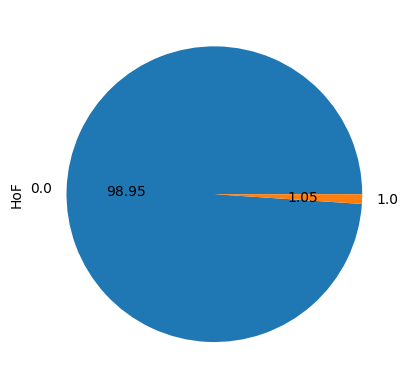

In [71]:
# Show pie plot
target.value_counts().plot.pie(autopct='%.2f')

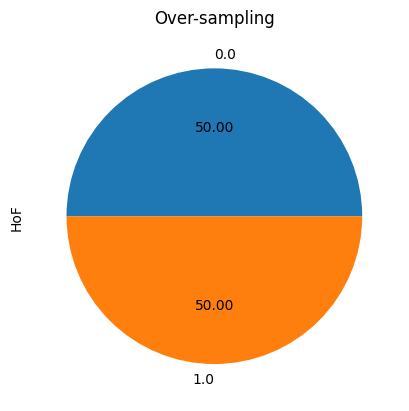

In [72]:
# Random Oversampling

from imblearn.over_sampling import RandomOverSampler # Float
ros = RandomOverSampler (sampling_strategy="not majority") # String
X_res, y_res = ros.fit_resample (feature, target)

ax = y_res.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Over-sampling")

In [73]:
y_res.value_counts()

0.0    6574
1.0    6574
Name: HoF, dtype: int64

In [74]:
X_res_train, X_res_test, y_res_train, y_res_test = train_test_split(X_res,y_res, test_size = 0.3, random_state = rs)

In [75]:
# creating Logistic Regression model
model = LogisticRegression(random_state = rs)
model.fit(X_res_train, y_res_train)
model.score(X_res_test, y_res_test)

0.9918884664131813

In [76]:
# Load packages for Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

In [77]:
# Instantiate a random forest model with 1000 decision trees
rf = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, min_samples_split=2, random_state=42)

#Train the model on training data
rf.fit(X_res_train, y_res_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [78]:
# Use the forest's predict method on the test data
y_res_pred_rf = rf.predict(X_res_test)

In [79]:
# Print the classification report
print(classification_report(y_res_test, y_res_pred_rf))

print("Test Accuracy: {}%".format(round(rf.score(X_res_test, y_res_test)*100,2)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1995
         1.0       1.00      1.00      1.00      1950

    accuracy                           1.00      3945
   macro avg       1.00      1.00      1.00      3945
weighted avg       1.00      1.00      1.00      3945

Test Accuracy: 99.9%


In [80]:
# cross-validation
scores = cross_val_score(estimator = model, X = X_res_train, y = y_res_train, cv = 10)
print('CV accuracy: %s' % scores)
print('CV accuracy range: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: [0.98697068 0.99348534 0.99239957 0.99130435 0.99021739 0.99782609
 0.99347826 0.99347826 0.99021739 0.99021739]
CV accuracy range: 0.992 +/- 0.003


**Oversampling did balance the dataset but the accuracy seems still very high.**

In [81]:
over_X_train = X_res_train

**Also, oversampling created unrecognizable 'PlayerID's.**

In [82]:
over_X_train.head()

,Years_Played,H,BB,HR,AVE,OBP,Slug_Percent,OPS,WAR,runs_br,...,1942-45_percent,G_dh_percent,1920-41_percent,G_ss_percent,post2009_percent,1977-92_percent,G_2b_percent,G_3b_percent,G_of_percent,pre1920_percent
12423,17,2660,856,183,0.341595,0.396875,0.520483,0.917358,72.19,-3.11,...,0.000000,0.000000,0.733458,0.000000,0.0,0.0,0.008388,0.000000,0.746971,0.266542
8671,22,2873,2062,714,0.342105,0.468915,0.689807,1.158722,162.20,-8.50,...,0.000000,0.000000,0.843450,0.000000,0.0,0.0,0.000000,0.000000,0.892572,0.156550
3399,3,145,57,24,0.267035,0.340984,0.432781,0.773764,2.42,-0.52,...,0.994083,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.704142,0.000000
5407,5,226,120,3,0.245119,0.328358,0.305857,0.634215,1.81,-0.94,...,0.000000,0.000000,0.000000,0.253823,0.0,1.0,0.733945,0.009174,0.000000,0.000000
6512,3,139,65,25,0.220635,0.294618,0.406349,0.700967,2.28,0.45,...,0.000000,0.010204,0.000000,0.005102,0.0,0.0,0.000000,0.943878,0.000000,0.000000


In [83]:
# Load the backup data as data2
data2 = df_hitters2

In [84]:
df_hitters2.head(100)

,nameFirst,nameLast,debut,finalGame,G,AB,R,H,2B,3B,...,OBP,Slug_Percent,OPS,name_common,WAR,WAR_off,runs_br,runs_dp,runs_field,YSLS
playerID,,,,,,,,,,,,,,,,,,,,,
abercda01,Frank,Abercrombie,1871-10-21,1871-10-21,1,4,0,0,0,0,...,0.000000,0.000000,0.000000,Frank Abercrombie,-0.07,-0.07,0.00,0.0,0.0,151.0
addybo01,Bob,Addy,1871-05-06,1877-10-06,274,1231,227,341,36,13,...,0.288569,0.329813,0.618382,Bob Addy,2.92,2.94,-2.23,0.0,2.0,145.0
allisar01,Art,Allison,1871-05-04,1876-10-05,168,741,106,188,19,8,...,0.258713,0.304993,0.563706,Art Allison,0.23,0.42,1.09,0.0,-2.0,146.0
barkeal01,Al,Barker,1871-06-01,1871-06-01,1,4,0,1,0,0,...,0.400000,0.250000,0.650000,Al Barker,0.03,0.03,0.01,0.0,0.0,151.0
barnero01,Ross,Barnes,1871-05-05,1881-09-21,499,2391,698,860,146,47,...,0.389310,0.467587,0.856897,Ross Barnes,28.03,24.49,5.20,0.0,57.0,141.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gedneco01,Count,Gedney,1872-04-27,1875-10-29,202,832,139,209,25,8,...,0.262722,0.318510,0.581232,Count Gedney,1.96,0.34,-1.42,0.0,24.0,147.0
hallji01,Jim,Hall,1872-05-20,1874-05-15,15,66,9,19,0,1,...,0.298507,0.318182,0.616689,Jim Hall,-0.16,0.10,0.15,0.0,-4.0,148.0
hinespa01,Paul,Hines,1872-04-20,1891-07-03,1658,7062,1217,2133,399,93,...,0.336965,0.409091,0.746056,Paul Hines,44.89,45.13,-5.76,0.0,19.0,131.0


In [85]:
# Select columns to use for models, and identification columns
num_cols_hitters = ['nameFirst', 'nameLast', 'HoF', 'Years_Played', 'H', 'BB', 'HR', 'AVE',
                    'OBP', 'Slug_Percent', 'OPS', 'WAR','runs_br','runs_field', 'RBI','R', 'SB', '2B',
                    '3B', 'AB', 'SO', 'Most Valuable Player', 'World Series MVP', 'AS_games','Gold Glove',
                    'Rookie of the Year', 'Silver Slugger', 'bats_R', 'throws_R', 'DPf', 'Af', 'Ef', 'YSLS', 'G_all',
                    '1963-76_percent', '1993-2009_percent', '1946-62_percent', 'G_1b_percent', '1942-45_percent',
                    'G_dh_percent', '1920-41_percent', 'G_ss_percent','post2009_percent', '1977-92_percent', 'G_2b_percent',
                    'G_3b_percent','G_of_percent', 'pre1920_percent']

# Create a new DataFrame (`data`) from the `df_hitters` using the columns above
data2 = df_hitters2[num_cols_hitters]

In [86]:
# Set a random state
rs= 42

# Create `target` Series
y = data2['HoF']

# Create `features` DataFrame
X = data2.copy()
X = data2.drop(['nameFirst', 'nameLast','HoF'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = rs)

In [87]:
#data2.set_index('playerID', inplace = True)

In [88]:
# standard scaling, neglecting our cols that do not need scaling due to their binary or percentage nature
data2 = list(X_train)
data_scalable = data2[6:]

# partially standard scaling
def standardscaling(X_train, X_test, scalable):
    scaler = StandardScaler()
    X_train[scalable] = scaler.fit_transform(X_train[scalable])
    X_test[scalable] = scaler.transform(X_test[scalable])
    return X_train, X_test, scaler

X_train, X_test, data_scaler = standardscaling(X_train, X_test, data_scalable)
X_train.head()

,Years_Played,H,BB,HR,AVE,OBP,Slug_Percent,OPS,WAR,runs_br,...,1942-45_percent,G_dh_percent,1920-41_percent,G_ss_percent,post2009_percent,1977-92_percent,G_2b_percent,G_3b_percent,G_of_percent,pre1920_percent
playerID,,,,,,,,,,,,,,,,,,,,,
woodji01,3,162,25,3,0.331967,0.364522,1.197225,1.099882,-0.082434,0.379686,...,-0.226257,-0.268014,-0.451293,-0.460878,0.0,-0.461386,3.407861,-0.476882,-0.892792,1.529505
budasma01,2,6,5,0,0.166667,0.268293,-0.665662,-0.466009,-0.392957,-0.067944,...,-0.226257,9.333690,-0.451293,-0.460878,0.0,2.538794,-0.485608,-0.476882,-0.494936,-0.670070
triplco01,6,334,123,27,0.255547,0.318689,0.495318,0.465936,-0.275750,-0.336807,...,4.488469,-0.268014,0.090361,-0.460878,0.0,-0.461386,-0.485608,-0.476882,0.935574,-0.670070
brownga01,13,582,242,84,0.257294,0.329666,0.838086,0.723177,0.370412,0.291018,...,-0.226257,1.473875,-0.451293,-0.460878,0.0,-0.461386,-0.485608,-0.476882,0.157874,-0.670070
palmede01,14,1229,502,275,0.250714,0.323780,1.235572,0.936056,0.642120,-0.966063,...,-0.226257,1.173067,-0.451293,-0.455291,0.0,0.089126,-0.485608,2.894656,-0.837526,-0.670070


In [89]:
# Load packages for Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

In [90]:
# Logistic Regression model
model = LogisticRegression(random_state = rs)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9954864593781344

In [91]:
# Instantiate a random forest model with 1000 decision trees
rf = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, min_samples_split=2, random_state=42)

#Train the model on training data
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [92]:
# Use the forest's predict method on the test data
y_pred_rf = rf.predict(X_test)


In [93]:
# Print the classification report
print(classification_report(y_test, y_pred_rf))

print("Test Accuracy: {}%".format(round(rf.score(X_test, y_test)*100,2)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1978
         1.0       0.87      0.81      0.84        16

    accuracy                           1.00      1994
   macro avg       0.93      0.91      0.92      1994
weighted avg       1.00      1.00      1.00      1994

Test Accuracy: 99.75%


In [94]:
# cross-validation
scores = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)
print('CV accuracy: %s' % scores)
print('CV accuracy range: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: [0.99569892 0.98709677 0.99354839 0.99354839 0.99354839 0.99569892
 0.99354839 0.99569892 0.99354839 1.        ]
CV accuracy range: 0.994 +/- 0.003


In [95]:
'''
# standard scaling, neglecting our cols that do not need scaling due to their binary or percentage nature
data = list(X_train)
data_scalable = data[30:]

# partially standard scaling
def standardscaling(X_train, X_test, scalable):
    scaler = StandardScaler()
    X_train[scalable] = scaler.fit_transform(X_train[scalable])
    X_test[scalable] = scaler.transform(X_test[scalable])
    return X_train, X_test, scaler

X_train, X_test, data_scaler = standardscaling(X_train, X_test, data_scalable)
X_train.head()
'''

'\n# standard scaling, neglecting our cols that do not need scaling due to their binary or percentage nature\ndata = list(X_train)\ndata_scalable = data[30:]\n\n# partially standard scaling\ndef standardscaling(X_train, X_test, scalable):\n    scaler = StandardScaler()\n    X_train[scalable] = scaler.fit_transform(X_train[scalable])\n    X_test[scalable] = scaler.transform(X_test[scalable])\n    return X_train, X_test, scaler\n\nX_train, X_test, data_scaler = standardscaling(X_train, X_test, data_scalable)\nX_train.head()\n'

In [96]:
#df_hitters.set_index('playerID', inplace = True)

In [97]:
# re-running logistic regression
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9954864593781344

In [98]:
# re-cross validation
scores = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)
print('CV accuracy: %s' % scores)
print('CV accuracy range: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: [0.99569892 0.98709677 0.99354839 0.99354839 0.99354839 0.99569892
 0.99354839 0.99569892 0.99354839 1.        ]
CV accuracy range: 0.994 +/- 0.003


In [99]:
'''
# determine optimal number of components
pca_model = PCA(n_components = len(data)) # all components
X_PCA = pca_model.fit_transform(X_train)

variance = pca_model.explained_variance_ratio_ #variance ratios

# cumulative sum of variance, for the first [n] features
cv = np.cumsum(np.round(pca_model.explained_variance_ratio_, decimals = 3)*100)
'''

'\n# determine optimal number of components\npca_model = PCA(n_components = len(data)) # all components\nX_PCA = pca_model.fit_transform(X_train)\n\nvariance = pca_model.explained_variance_ratio_ #variance ratios\n\n# cumulative sum of variance, for the first [n] features\ncv = np.cumsum(np.round(pca_model.explained_variance_ratio_, decimals = 3)*100)\n'

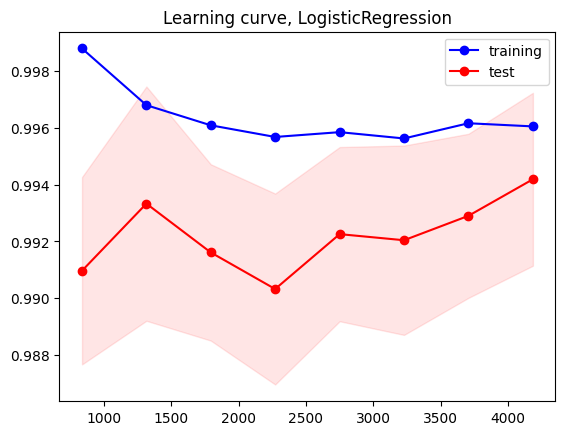

In [100]:
# plot learning curve
pipe_lr = Pipeline([('clf', model)])
train_sizes, train_scores, test_scores = \
                learning_curve(estimator = pipe_lr,
                        X = X_train, y = y_train,
                        train_sizes = np.linspace(0.2, 1.0, 8),
                        cv = 10)

# learning curve ranges
def learningcurve_ranges(train_scores, test_scores):
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)
    test_mean = np.mean(test_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)
    return train_mean, train_std, test_mean, test_std

# plotting learning curve
def plot_learningcurve(train_sizes, train_scores, test_scores, model_name):
    train_mean, train_std, test_mean, test_std = learningcurve_ranges(train_scores, test_scores)
    plt.plot(train_sizes, train_mean, 'b', marker='o')
    plt.plot(train_sizes, test_mean, 'r', marker='o')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color = 'red', alpha = 0.1)

    plt.title('Learning curve, {}'.format(model_name))
    plt.legend(('training', 'test'), fancybox = True)
    plt.show()

plot_learningcurve(train_sizes, train_scores, test_scores, 'LogisticRegression')

Model score: 0.9939819458375125
CV accuracy: [0.99569892 0.99569892 0.99784946 0.99354839 0.99354839 0.99354839
 0.99569892 0.99784946 0.99139785 0.99784946]
CV accuracy range: 0.995 +/- 0.002


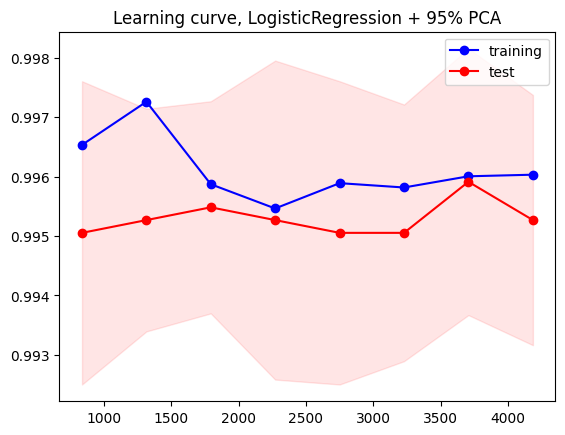

In [101]:
# PCA models
PCA_hit = PCA(n_components = 7) # 95%

# fit PCA, 98%
X_train_PCA = PCA_hit.fit_transform(X_train)
X_test_PCA = PCA_hit.transform(X_test)

# re-running logistic regression
model.fit(X_train_PCA, y_train)
print('Model score: {}'.format(model.score(X_test_PCA, y_test)))

# cross-validation
scores = cross_val_score(estimator = model, X = X_train_PCA, y = y_train, cv = 10)
print('CV accuracy: %s' % scores)
print('CV accuracy range: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

# plot learning curve
pipe_lr = Pipeline([('clf', model)])
train_sizes, train_scores, test_scores = \
                learning_curve(estimator = pipe_lr,
                        X = X_train_PCA, y = y_train,
                        train_sizes = np.linspace(0.2, 1.0, 8),
                        cv = 10)
plot_learningcurve(train_sizes, train_scores, test_scores, 'LogisticRegression + 95% PCA')

In [102]:
#data = df_hitters

In [103]:
#df_hitters.set_index('playerID', inplace = True)

In [104]:
# standard scaling and PCA
X_train, X_test, data_scaler = standardscaling(X_train, X_test, data_scalable)
X_train_PCA = PCA_hit.fit_transform(X_train)
X_test_PCA = PCA_hit.transform(X_test)

In [105]:
# helper function for classification
def model_score(model):
    model.fit(X_train_PCA, y_train)
    test_score = model.score(X_test_PCA, y_test)
    return test_score

In [106]:
# build a hitters HoF model
hitters_model = LogisticRegression(random_state = rs)

# fit PCA, 98%
X_train_PCA = PCA_hit.fit_transform(X_train)
X_test_PCA = PCA_hit.transform(X_test)

# rerunning logistic regression
hitters_model.fit(X_train_PCA, y_train)

# cross-validation
scores = cross_val_score(estimator = hitters_model, X = X_train_PCA, y = y_train, cv = 10)
print('CV accuracy: %s' % scores)
print('CV accuracy range: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: [0.99569892 0.99569892 0.99784946 0.99569892 0.99354839 0.99354839
 0.99569892 0.99784946 0.99139785 0.99784946]
CV accuracy range: 0.995 +/- 0.002


In [107]:
# output dataframe
output = pd.DataFrame(hitters_model.predict(X_test_PCA))
output.index= y_test.index
hitters_pred = pd.concat([y_test, output], axis = 1)
hitters_pred.rename({0: 'predicted'}, axis = 1, inplace = True)
hitters_pred.T

playerID,chrisjo02,acostme01,letchch01,weberjo01,morriji01,dambi01,breweto02,smithto03,higgipi01,yalead01,...,anderda02,thompmi02,muellbi01,nelsoro01,buncejo01,conceon01,whitmfr01,dreesbi01,gonzaju02,roberdo01
HoF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
predicted,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
hitters_pred.head()

,HoF,predicted
playerID,,
chrisjo02,0.0,0.0
acostme01,0.0,0.0
letchch01,0.0,0.0
weberjo01,0.0,0.0
morriji01,0.0,0.0


In [109]:
# Full prediction list of all players
hitters_pred[hitters_pred.predicted == 1]

,HoF,predicted
playerID,,
brocklo01,1.0,1.0
whitalo01,0.0,1.0
henderi01,1.0,1.0
alomaro01,1.0,1.0
morgajo02,1.0,1.0
rosepe01,0.0,1.0
hornsro01,1.0,1.0
mantlmi01,1.0,1.0
boyerke01,0.0,1.0


In [110]:
# Correct prediction on players who got inducted into Hall of Fame
hitters_pred[(hitters_pred.HoF == 1) & (hitters_pred.predicted == 1)]

,HoF,predicted
playerID,,
brocklo01,1.0,1.0
henderi01,1.0,1.0
alomaro01,1.0,1.0
morgajo02,1.0,1.0
hornsro01,1.0,1.0
mantlmi01,1.0,1.0
aaronha01,1.0,1.0
molitpa01,1.0,1.0
wagneho01,1.0,1.0


In [111]:
# generally, we do pretty well with the prediction
hitters_model.score(X_test_PCA, y_test)

0.9944834503510531

In [ ]:
'''
# Select columns to use for models, and identification columns
num_cols_hitters = ['nameFirst', 'nameLast', 'HoF', 'Years_Played', 'H', 'BB', 'HR', 'AVE',
                    'OBP', 'Slug_Percent', 'OPS', 'WAR','runs_br','runs_field', 'RBI','R', 'SB', '2B',
                    '3B', 'AB', 'SO', 'Most Valuable Player', 'World Series MVP', 'AS_games','Gold Glove',
                    'Rookie of the Year', 'Silver Slugger', 'bats_R', 'throws_R', 'DPf', 'Af', 'Ef', 'YSLS', 'G_all',
                    '1963-76_percent', '1993-2009_percent', '1946-62_percent', 'G_1b_percent', '1942-45_percent',
                    'G_dh_percent', '1920-41_percent', 'G_ss_percent','post2009_percent', '1977-92_percent', 'G_2b_percent',
                    'G_3b_percent','G_of_percent', 'pre1920_percent']

# Create a new DataFrame (`data`) from the `df_hitters` using the columns above
data_act = df_eligible[num_cols_hitters]

# Return the first rows of `data`
print(data_act.head())
'''

"\n# Select columns to use for models, and identification columns\nnum_cols_hitters = ['nameFirst', 'nameLast', 'HoF', 'Years_Played', 'H', 'BB', 'HR', 'AVE',\n                    'OBP', 'Slug_Percent', 'OPS', 'WAR','runs_br','runs_field', 'RBI','R', 'SB', '2B',\n                    '3B', 'AB', 'SO', 'Most Valuable Player', 'World Series MVP', 'AS_games','Gold Glove',\n                    'Rookie of the Year', 'Silver Slugger', 'bats_R', 'throws_R', 'DPf', 'Af', 'Ef', 'YSLS', 'G_all',\n                    '1963-76_percent', '1993-2009_percent', '1946-62_percent', 'G_1b_percent', '1942-45_percent',\n                    'G_dh_percent', '1920-41_percent', 'G_ss_percent','post2009_percent', '1977-92_percent', 'G_2b_percent',\n                    'G_3b_percent','G_of_percent', 'pre1920_percent']\n\n# Create a new DataFrame (`data`) from the `df_hitters` using the columns above\ndata_act = df_eligible[num_cols_hitters]\n\n# Return the first rows of `data`\nprint(data_act.head())\n"

In [ ]:
# Import players dataset into a dataframe
players_df = pd.read_csv('People.csv')


In [ ]:
# Concatenate first name and last name
players_df['name'] = players_df['nameFirst'] + ' ' + players_df['nameLast']

In [ ]:
# Reset 'player_id' as index
players_df.set_index('playerID', inplace = True)

In [ ]:
players_df.head()

,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,deathCountry,...,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID,name
playerID,,,,,,,,,,,,,,,,,,,,,
aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,NaN,...,David Allan,215.0,75.0,R,R,2004-04-06,2015-08-23,aardd001,aardsda01,David Aardsma
aaronha01,1934.0,2.0,5.0,USA,AL,Mobile,2021.0,1.0,22.0,USA,...,Henry Louis,180.0,72.0,R,R,1954-04-13,1976-10-03,aaroh101,aaronha01,Hank Aaron
aaronto01,1939.0,8.0,5.0,USA,AL,Mobile,1984.0,8.0,16.0,USA,...,Tommie Lee,190.0,75.0,R,R,1962-04-10,1971-09-26,aarot101,aaronto01,Tommie Aaron
aasedo01,1954.0,9.0,8.0,USA,CA,Orange,NaN,NaN,NaN,NaN,...,Donald William,190.0,75.0,R,R,1977-07-26,1990-10-03,aased001,aasedo01,Don Aase
abadan01,1972.0,8.0,25.0,USA,FL,Palm Beach,NaN,NaN,NaN,NaN,...,Fausto Andres,184.0,73.0,L,L,2001-09-10,2006-04-13,abada001,abadan01,Andy Abad


In [ ]:
# Make a dataframe for incorrect predictions
wrong_hitters = hitters_pred[hitters_pred['HoF'] != hitters_pred['predicted']]
wrong_hitters.merge(players_df[['name']], left_index = True, right_index = True).T

playerID,whitalo01,heilmha01,mccovwi01,robinja02,rosepe01,greenha01,boyerke01,bellbu01,medwijo01,garvest01,terrybi01
HoF,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
predicted,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
name,Lou Whitaker,Harry Heilmann,Willie McCovey,Jackie Robinson,Pete Rose,Hank Greenberg,Ken Boyer,Buddy Bell,Joe Medwick,Steve Garvey,Bill Terry


In [ ]:
wrong_hitters

,HoF,predicted
playerID,,
whitalo01,0.0,1.0
heilmha01,1.0,0.0
mccovwi01,1.0,0.0
robinja02,1.0,0.0
rosepe01,0.0,1.0
greenha01,1.0,0.0
boyerke01,0.0,1.0
bellbu01,0.0,1.0
medwijo01,1.0,0.0


In [ ]:
'''
#Create column for years since retirement
df['YSLS'] = 2022 - df['finalYear']

#Filter 'df' for players who retired more that 15 yrs ago
df_hitters = df[df['YSLS'] > 15]

print(df_hitters.head())
print(len(df_hitters[df_hitters['HoF'] == 1]))

#Filter `df` for players who retired less than 15 years ago and for currently active players
df_eligible = df[df['YSLS'] <= 15]

print(df_eligible.head())

print(df.columns)
'''

"\n#Create column for years since retirement\ndf['YSLS'] = 2022 - df['finalYear']\n\n#Filter 'df' for players who retired more that 15 yrs ago\ndf_hitters = df[df['YSLS'] > 15]\n\nprint(df_hitters.head())\nprint(len(df_hitters[df_hitters['HoF'] == 1]))\n\n#Filter `df` for players who retired less than 15 years ago and for currently active players\ndf_eligible = df[df['YSLS'] <= 15]\n\nprint(df_eligible.head())\n\nprint(df.columns)\n"

In [ ]:
df_eligible.head()

,playerID,nameFirst,nameLast,debut,finalGame,G,AB,R,H,2B,...,OBP,Slug_Percent,OPS,name_common,WAR,WAR_off,runs_br,runs_dp,runs_field,YSLS
5462,francju01,Julio,Franco,1982-04-23,2007-09-17,2527,8677,1285,2586,407,...,0.363889,0.417195,0.781083,Julio Franco,43.57,48.49,16.84,-25.33,-32.3,15.0
5689,bondsba01,Barry,Bonds,1986-05-30,2007-09-26,2986,9847,2227,2935,601,...,0.444154,0.606885,1.051039,Barry Bonds,162.77,143.61,43.59,5.61,143.8,15.0
5867,sheffga01,Gary,Sheffield,1988-09-03,2009-09-30,2576,9217,1636,2689,467,...,0.392710,0.513942,0.906652,Gary Sheffield,60.54,80.74,-1.04,-10.62,-179.3,13.0
5893,finlest01,Steve,Finley,1989-04-03,2007-06-03,2583,9397,1443,2548,449,...,0.329350,0.442375,0.771725,Steve Finley,44.20,44.46,28.85,33.46,-11.8,15.0
5896,griffke02,Ken,Griffey,1989-04-03,2010-05-31,2671,9801,1662,2781,524,...,0.369250,0.537802,0.907052,Ken Griffey Jr.,83.84,84.59,15.70,9.15,-49.6,12.0


In [ ]:
print(len(df_eligible[df_eligible['HoF'] == 1]))

7


In [ ]:
df_eligible.set_index('playerID', inplace = True)

KeyError: ignored

In [ ]:
#prediction_df.loc[['griffke02', 'piazzmi01', 'bagweje01', 'raineti01', 'rodriiv01', 'jonesch06', 'guerrvl01', 'thomeji01', 'hoffmtr01']]

In [ ]:
'''
players = ['griffke02', 'piazzmi01', 'bagweje01', 'raineti01', 'rodriiv01', 'jonesch06', 'guerrvl01', 'thomeji01', 'hoffmtr01']

prediction_df.loc[prediction_df.index['playerID'].isin(players)]
'''

"\nplayers = ['griffke02', 'piazzmi01', 'bagweje01', 'raineti01', 'rodriiv01', 'jonesch06', 'guerrvl01', 'thomeji01', 'hoffmtr01']\n\nprediction_df.loc[prediction_df.index['playerID'].isin(players)]\n"

In [ ]:
# Select columns to use for models, and identification columns
num_cols_hitters = ['nameFirst', 'nameLast', 'HoF', 'Years_Played', 'H', 'BB', 'HR', 'AVE',
                    'OBP', 'Slug_Percent', 'OPS', 'WAR','runs_br','runs_field', 'RBI','R', 'SB', '2B',
                    '3B', 'AB', 'SO', 'Most Valuable Player', 'World Series MVP', 'AS_games','Gold Glove',
                    'Rookie of the Year', 'Silver Slugger', 'bats_R', 'throws_R', 'DPf', 'Af', 'Ef', 'YSLS', 'G_all',
                    '1963-76_percent', '1993-2009_percent', '1946-62_percent', 'G_1b_percent', '1942-45_percent',
                    'G_dh_percent', '1920-41_percent', 'G_ss_percent','post2009_percent', '1977-92_percent', 'G_2b_percent',
                    'G_3b_percent','G_of_percent', 'pre1920_percent']

# Create a new DataFrame (`data`) from the `df_hitters` using the columns above
#data = df_hitters[num_cols_hitters]
data1 = df_eligible[num_cols_hitters]

# Return the first rows of `data`
print(data1.head())

#'OPS', 'WAR','runs_br','runs_field', 'bats_R', 'throws_R'

          nameFirst   nameLast  HoF  Years_Played     H    BB   HR       AVE  \
playerID                                                                       
francju01     Julio     Franco  0.0            23  2586   917  173  0.298029   
bondsba01     Barry      Bonds  0.0            22  2935  2558  762  0.298060   
sheffga01      Gary  Sheffield  0.0            22  2689  1475  509  0.291744   
finlest01     Steve     Finley  0.0            19  2548   844  304  0.271150   
griffke02       Ken    Griffey  1.0            22  2781  1312  630  0.283747   

                OBP  Slug_Percent  ...  1942-45_percent  G_dh_percent  \
playerID                           ...                                  
francju01  0.363889      0.417195  ...              0.0      0.148397   
bondsba01  0.444154      0.606885  ...              0.0      0.013061   
sheffga01  0.392710      0.513942  ...              0.0      0.117236   
finlest01  0.329350      0.442375  ...              0.0      0.005420   
g

In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1814 entries, francju01 to youngja02
Data columns (total 48 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   nameFirst             1814 non-null   object 
 1   nameLast              1814 non-null   object 
 2   HoF                   1814 non-null   float64
 3   Years_Played          1814 non-null   int64  
 4   H                     1814 non-null   int64  
 5   BB                    1814 non-null   int64  
 6   HR                    1814 non-null   int64  
 7   AVE                   1814 non-null   float64
 8   OBP                   1814 non-null   float64
 9   Slug_Percent          1814 non-null   float64
 10  OPS                   1814 non-null   float64
 11  WAR                   1814 non-null   float64
 12  runs_br               1814 non-null   float64
 13  runs_field            1814 non-null   float64
 14  RBI                   1814 non-null   float64
 15  R            

In [ ]:

# standard scaling, neglecting our cols that do not need scaling due to their binary or percentage nature
data1 = list(X_train)
data1_scalable = data1[18:]

# partially standard scaling
def standardscaling(X_train, X_test, scalable):
    scaler = StandardScaler()
    X_train[scalable] = scaler.fit_transform(X_train[scalable])
    X_test[scalable] = scaler.transform(X_test[scalable])
    return X_train, X_test, scaler

X_train, X_test, data1_scaler = standardscaling(X_train, X_test, data1_scalable)
X_train.head()


,Years_Played,H,BB,HR,AVE,OBP,Slug_Percent,OPS,WAR,runs_br,...,1942-45_percent,G_dh_percent,1920-41_percent,G_ss_percent,post2009_percent,1977-92_percent,G_2b_percent,G_3b_percent,G_of_percent,pre1920_percent
playerID,,,,,,,,,,,,,,,,,,,,,
woodji01,3,162,25,3,0.331967,0.364522,1.197225,1.099882,-0.082434,0.379686,...,-0.226257,-0.268014,-0.451293,-0.460878,0.0,-0.461386,3.407861,-0.476882,-0.892792,1.529505
budasma01,2,6,5,0,0.166667,0.268293,-0.665662,-0.466009,-0.392957,-0.067944,...,-0.226257,9.333690,-0.451293,-0.460878,0.0,2.538794,-0.485608,-0.476882,-0.494936,-0.670070
triplco01,6,334,123,27,0.255547,0.318689,0.495318,0.465936,-0.275750,-0.336807,...,4.488469,-0.268014,0.090361,-0.460878,0.0,-0.461386,-0.485608,-0.476882,0.935574,-0.670070
brownga01,13,582,242,84,0.257294,0.329666,0.838086,0.723177,0.370412,0.291018,...,-0.226257,1.473875,-0.451293,-0.460878,0.0,-0.461386,-0.485608,-0.476882,0.157874,-0.670070
palmede01,14,1229,502,275,0.250714,0.323780,1.235572,0.936056,0.642120,-0.966063,...,-0.226257,1.173067,-0.451293,-0.455291,0.0,0.089126,-0.485608,2.894656,-0.837526,-0.670070


In [ ]:
## Predicting the Future Hall of Famers

# Filter out players who have not yet hit 10 season
#data1 = data1[data1.Years_Played >= 10]

# Print 'active/eligible players with 10+ seasons
print('Total number of active/eligible players with 10+ seasons: {}'.format(len(data1)))

# Replace NaN with 0
data1.fillna(value = 0, inplace = True)

X_AH = data1

#X_AH = data1.drop
X_AH = data1.drop(['nameFirst', 'nameLast','HoF'], axis=1)

# standard scaling
X_AH[data1_scalable] = data1_scaler.transform(X_AH[data1_scalable])
X_AH = PCA_hit.transform(X_AH)

# prediction
data1['prediction'] = hitters_model.predict(X_AH)

# joining to dataframe of names
prediction_hit = df_eligible.merge(data1[['prediction']], how = 'right', left_index = True, right_index = True)
prediction_hit = prediction_hit[prediction_hit.Years_Played >= 10]
prediction_hit.sort_values(by = 'prediction', inplace = True, ascending = False)

# full list of predictions
prediction_hit[prediction_hit.prediction == 1]

Total number of active/eligible players with 10+ seasons: 45


AttributeError: ignored

In [ ]:
# full list of correct predictions
prediction_hit[(prediction_hit.HoF == 1) & (prediction_hit.prediction == 1)]

NameError: ignored

In [ ]:
'''
recent_HOF = ['griffke02', 'piazzmi01', 'bagweje01', 'raineti01', \
              'rodriiv01', 'jonesch06', 'guerrvl01', 'thomeji01', 'hoffmtr01']
prediction_hit.index[recent_HOF]
'''

"\nrecent_HOF = ['griffke02', 'piazzmi01', 'bagweje01', 'raineti01',               'rodriiv01', 'jonesch06', 'guerrvl01', 'thomeji01', 'hoffmtr01']\nprediction_hit.index[recent_HOF]\n"